# **Mobile Health Assessment 1**

This document contains your first assigment. First copy the colab notebook into your own google drive. Do not edit this version. Please fill in code where required in your copy, and answer the questions on an answer sheet (Word, Google Doc, LaTeX -- or anything else you prefer) . Clearly indicate which answers belong to which questions.

When you see this symbol ❓, fill in the answer in your answer sheet. Otherwise, only provide the code snippet and output of the code block. Include relevant images that you produce in this notebook on your answer sheet.

**Word limit:** Your answer sheet has a word limit of 1000 words. Please provide a word count at the end of the document. References and figure and table captions are not included in the word count.

## Submission instructions:
You need to submit both the colab notebook and your answer sheet.
1. Use the share option (right top) in colab to get a publicly sharable link. Put it in a .txt file named as colab.txt.
2. Download the colab as a .ipynb file.
3. Save the answer sheet as a pdf file.
4. Put all the above three files in a directory named as *your CRSID*. Also include your self-recorded wav file inside this folder. Then zip it and upload it to Moodle.

##Data instructions:
To access the data with this colab you need to save the data to your own google drive.

Go to this link to access the data: https://drive.google.com/drive/folders/1tT8t5Quna7tcY8DuZi8psdX7mH8BKCDA?usp=sharing

Then right click on the folder (mobile-health-assignment-1) and click 'add shortcut to drive".

## Background

In this assignment, you will be working on heart sound data. To make it easier for you, we believe it might be beneficial to have some basic knowledge about the physiology of heart sounds.

Human heart has four valves that open and snap shut during the heartbeat to let the blood into the heart and let it out as shown in the below figure. During a single heartbeat, there are two sounds present, commonly referred to as S1 and S2, and are produced by the heart valves snapping shut. When the valves are not working as they should, they let some blood through, causing excessive blood turbulence and an additional sound known as murmur.

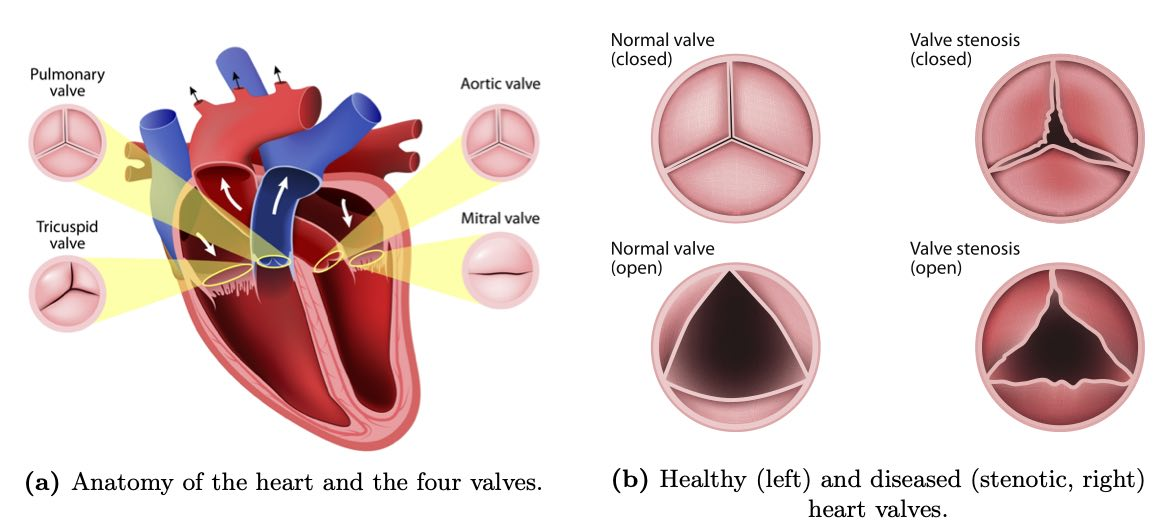

The different heart sounds produced in a healthy and diseased heart are shown in the below image. 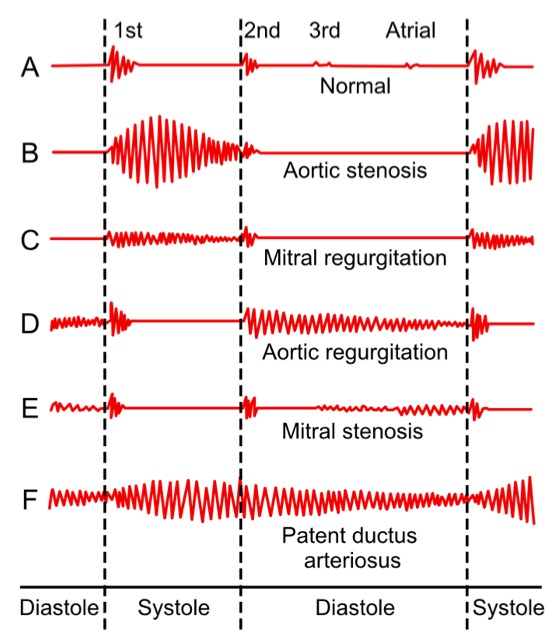

A cardiologist typically starts their diagnosis by listening to the patient's chest using a stethoscope, a process called auscultation. For cardiac auscultation, a doctor would listen to four locations on the chest, corresponding to the four valves in the heart. The cardiologist then can identify the diseased valve based on the timing of the murmur (whether it occurs between S1 and S2 or S2 and S1) and based on its shape. If a patient has a murmur present, it would commonly be caused by a pathology in one of the four valves. If the valve pathology is advanced, the murmur is likely to be high in amplitude and be audible from all four locations on the chest, whereas if the murmur is mild, it may only manifest in a few locations that are closer to the diseased valve, and not be audible from other locations.

Run the cells below to install and import some of the necessary libraries. Add additional libraries according to your needs.

In [1]:
# import the dependencies
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Times New Roman' # set font to times new roman everywhere
import pandas as pd
# import opensmile
import numpy as np
from scipy.signal import butter,sosfiltfilt, find_peaks
import os

In [ ]:
# from google.colab import files
#from google.colab import drive
# drive.mount('/content/drive')

## Part 1: Audio Processing Basics [25 marks]

**Task 1.1**: Load the two files in the Task_1_1 folder

Hints:

1.   The google drive folder for the assigment is located at "/content/drive/My Drive/mobile-health-assignment-1"
2.   You can use [librosa.load](https://librosa.org/doc/main/generated/librosa.load.html) to load the audio file.
Pay attention to sampling rates when loading the files, we want to maintain the native sampling rate of the file.



In [2]:
#TV_signal, TV_sr = librosa.load('/content/drive/MyDrive/Cambridge/Studies/Lent/MobileHealth/Assessment1/mobile-health-assignment-1/task_1_1/29045_TV.wav', sr=None)
#AV_signal, AV_sr = librosa.load('/content/drive/MyDrive/Cambridge/Studies/Lent/MobileHealth/Assessment1/mobile-health-assignment-1/task_1_1/49876_AV.wav', sr=None)

TV_signal, TV_sr = librosa.load('data/mobile-health-assignment-1/task_1_1/29045_TV.wav', sr=None)
AV_signal, AV_sr = librosa.load('data/mobile-health-assignment-1/task_1_1/49876_AV.wav', sr=None)

print(f'Data loaded successfully. TV SR: {TV_sr}, AV SR: {AV_sr}')

Data loaded successfully. TV SR: 4000, AV SR: 4000


**Task 1.2**: Display the two files in the time domain. Hint: displaying in time domain is the same whether you're working with PPG or audio data.


---


❓ Discuss any differences between the two files in the time domain, giving possible reasons.

❓ Based on the above, can you visually differentiate between the murmur and non-murmur heart sounds? Predict which is the murmur and which is the non-murmur.

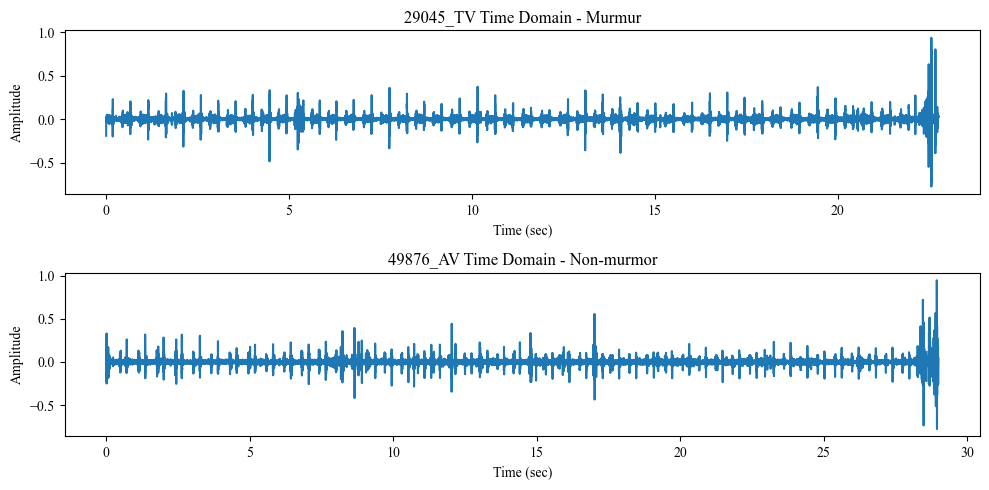

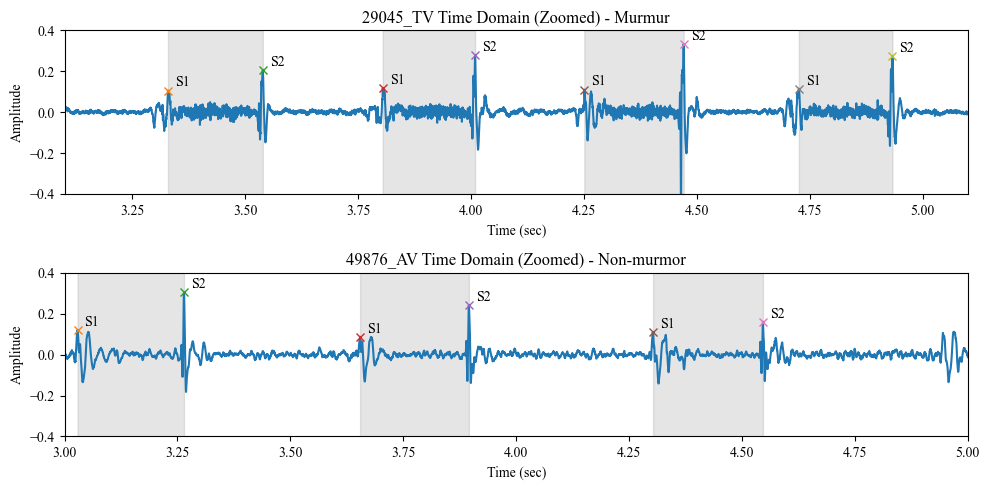

In [3]:
def plot_time_domain(signal, times, title, row, col, index, xlim=None, ylim=None, peaks=False, sr=None):
    ax = plt.subplot(row, col, index)
    ax.plot(times, signal)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # try to find peaks and mark S1 & S2 automatically!
    if peaks:
        min_distance_points = int(0.1 * sr) # set minimum distance in seconds and convert it to data points using the sampling rate
        peak_indices, _ = find_peaks(signal, height=0.06, distance=min_distance_points) # find peaks using scipy find_peaks
        
        # only look at peaks within defined xlim
        if xlim:
            peak_indices = [idx for idx in peak_indices if xlim[0] <= times[idx] <= xlim[1]]

        # annotate peaks, alternating between S1 and S2 --> important: consider xlim, otherwise S2 might be annoated as S1
        for i, idx in enumerate(peak_indices):
            label = 'S1' if i % 2 == 0 else 'S2'
            ax.plot(times[idx], signal[idx], 'x')
            ax.annotate(label, (times[idx], signal[idx]), textcoords='offset points', xytext=(5,3))
            
            # highlight area between S1 and S2, if S1 found and not at the end
            if label == 'S1' and i + 1 < len(peak_indices):
                s2_idx = peak_indices[i + 1]
                ax.fill_between(times, ylim[0], ylim[1], where=(times >= times[idx]) & (times <= times[s2_idx]), color='grey', alpha=0.2)
    
    ax.set_title(title)
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')

# normalize?
# TV_signal = (TV_signal-min(TV_signal))/(max(TV_signal)-min(TV_signal))
# AV_signal = (AV_signal-min(AV_signal))/(max(AV_signal)-min(AV_signal))

# Step I: Creating time axis for TV and AV signal respectively
TV_time = np.linspace(0, len(TV_signal) / TV_sr, num=len(TV_signal))
AV_time = np.linspace(0, len(AV_signal) / AV_sr, num=len(AV_signal))


# Step II: Plot for both files (not zoomed)
plt.figure(figsize=(10, 5))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
xlim = None
ylim = None

plot_time_domain(TV_signal, TV_time, '29045_TV Time Domain - Murmur', 2, 1, 1, xlim, ylim)
plot_time_domain(AV_signal, AV_time, '49876_AV Time Domain - Non-murmor', 2, 1, 2, xlim, ylim)

plt.tight_layout()
plt.show()


# Step III: zoomed with annotation
plt.figure(figsize=(10, 5))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
xlim = (3, 5)
ylim = (-0.4, 0.4)

plot_time_domain(TV_signal, TV_time, '29045_TV Time Domain (Zoomed) - Murmur', 2, 1, 1, (3.1, 5.1), ylim, peaks=True, sr=TV_sr) # sampling rate only required for peaks
plot_time_domain(AV_signal, AV_time, '49876_AV Time Domain (Zoomed) - Non-murmor', 2, 1, 2, xlim, ylim, peaks=True, sr=AV_sr)

plt.tight_layout()
plt.show()

**Task 1.3**: Display the data in the frequency domain. Give both the FFT and a melspectrogram for each file.


---

❓ Discuss any differences between the frequency domain representations of the murmur and non-murmur files.

❓ Are there any features that are evident in the frequency domain that you could not distinguish in the time domain?

Hint: [Librosa melspectrogram](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html) and [specshow](https://librosa.org/doc/main/generated/librosa.display.specshow.html) can be used for displaying spectrograms.
Make sure to look at different spectrogram parameters to obtain different time and frequency resolution and thus extract different
information from the spectrograms. You should be able to clearly see heart beats if you've selected your spectrogram parameters correctly.


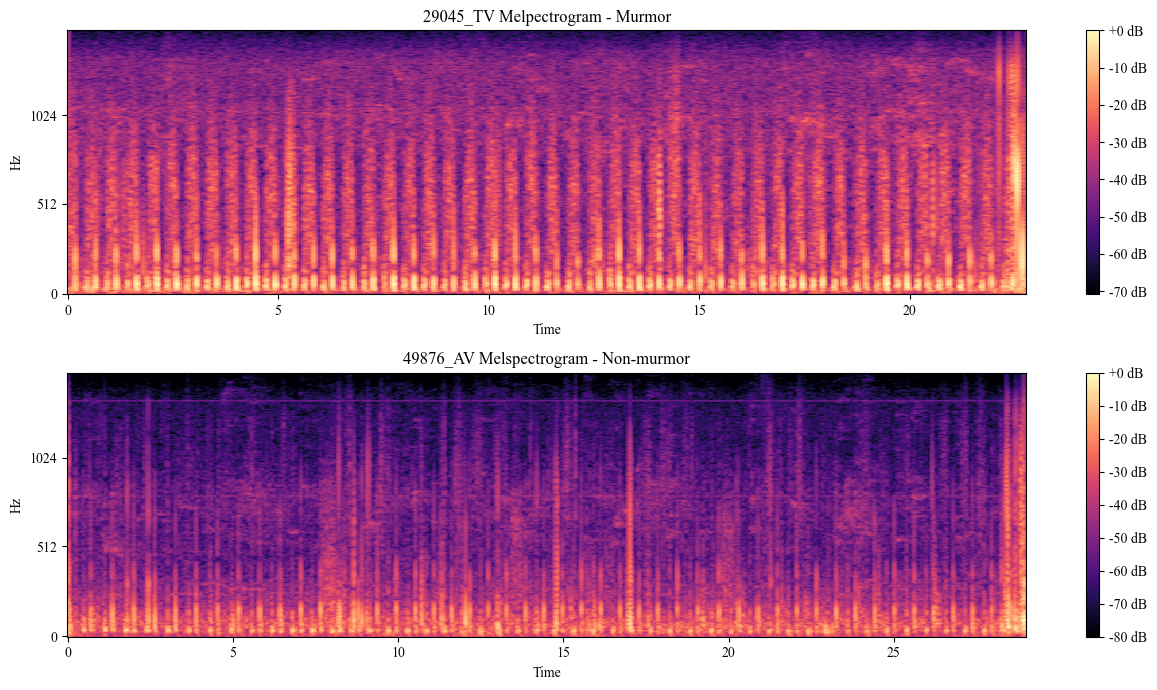

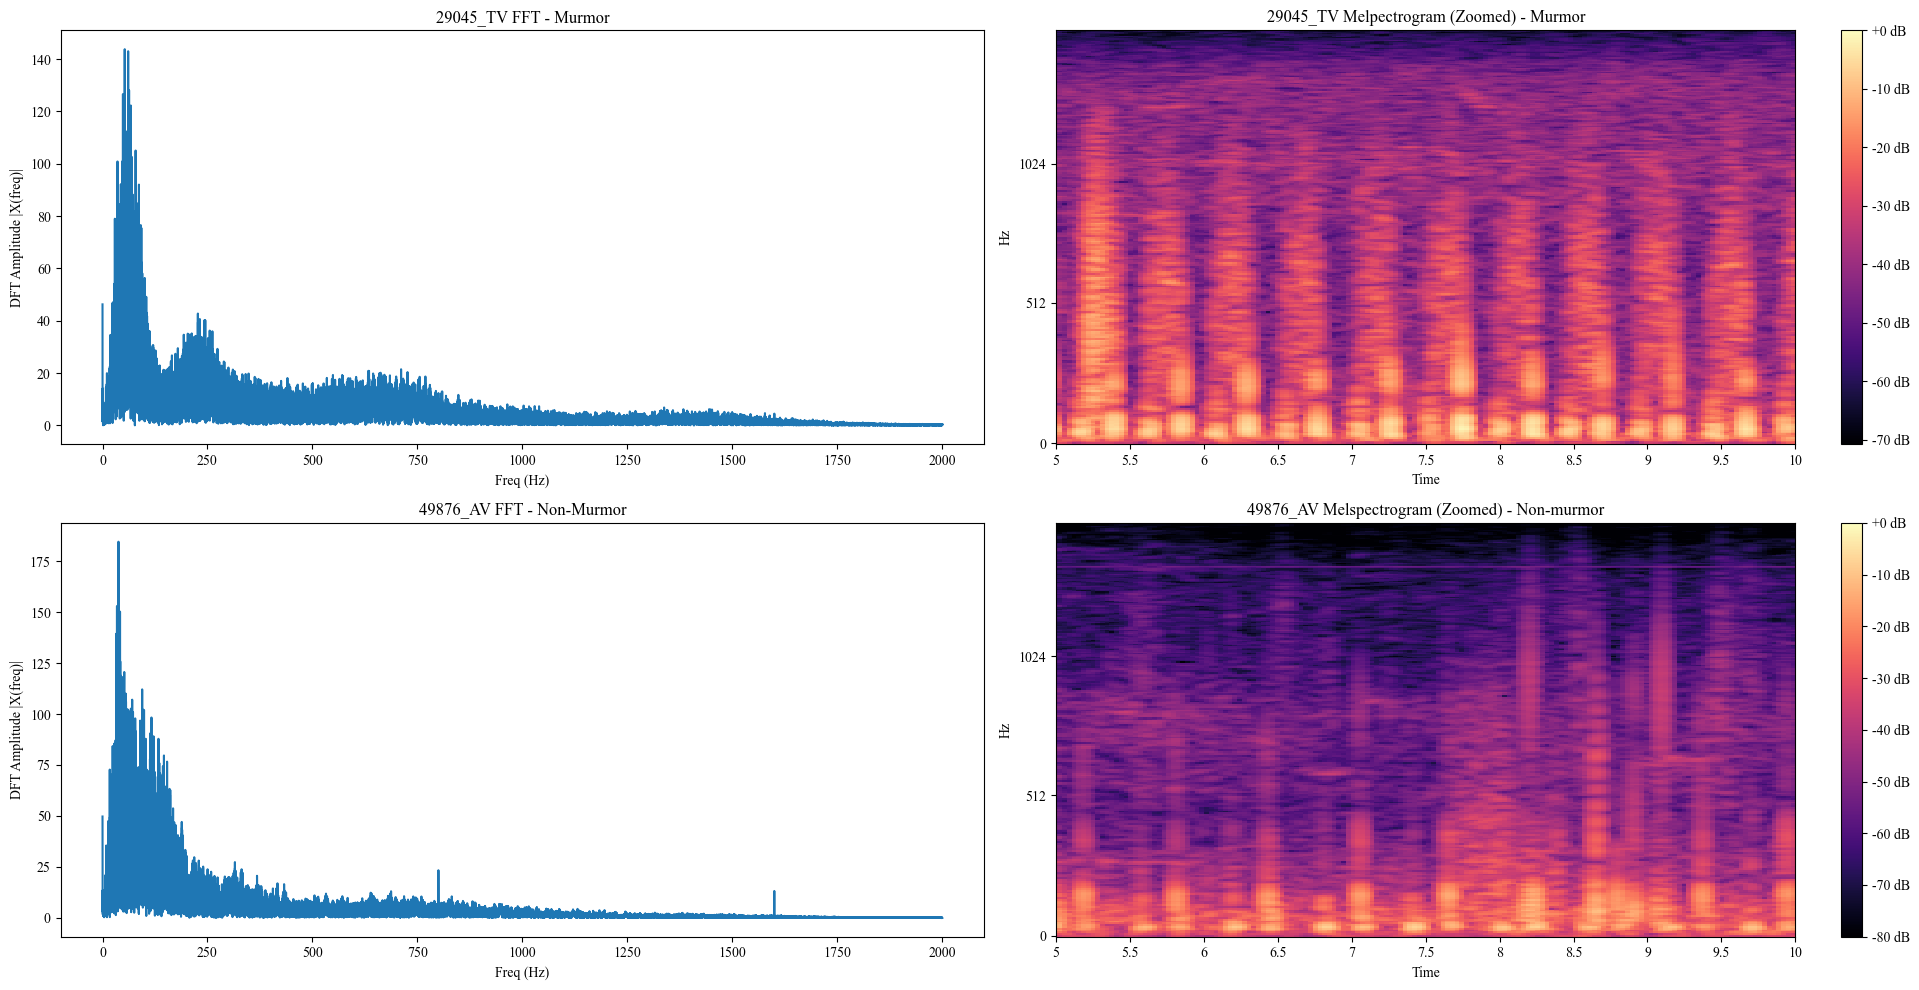

In [4]:
def plot_frequency_domain(signal, sr, title, row, col, index, xlim=None, ylim=None):
  # transform signal into FFT using DFTs (Discrete Fourier Transform), specficically the (one-dimensional) Fast Fourier Transform (FFT) --> lecture 2
  fft = np.fft.fft(signal) # using numpy's fft function to get one-dimensional discrete Fourier Transform
  frequency_bins = np.fft.fftfreq(len(fft), d=1/sr) # Discrete Fourier Transform sample frequencies (define d (=sample spacing) as inverse of our sampling rate)

  # Note: sampling rate is fixed --> need to avoid aliasing (i.e. we can only trust frequencies up to half of the sampling rate) --> only look at first half
  fft = fft[:len(fft)//2]
  frequency_bins = frequency_bins[:len(frequency_bins)//2]
  # only look at positive half
  fft = np.abs(fft)

  # plot frequency domain graph
  ax = plt.subplot(row, col, index)
  ax.plot(frequency_bins, fft)
  if xlim:
    ax.set_xlim(xlim)
  if ylim:
    ax.set_ylim(ylim)
  ax.set_title(title)
  ax.set_xlabel('Freq (Hz)')
  ax.set_ylabel('DFT Amplitude |X(freq)|')

def plot_melspectrogram(signal, sr, title, row, col, index, xlim=None, ylim=None, n_fft=2048, hop_length=512, n_mels=128):
    '''
    :param n_fft: the length of the FFT window to be used for the STFT (essentially the freq resolution) (default: 1024)
    :param hop_length: the number of samples between successive frames (default: 512)
    :param n_mels: the number of mel bands to generate (default: 128)
    '''
    # compute melspectrogram using librosa library
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    # convert amplitude spectogram to dB-scaled spectogram
    S_DB = librosa.power_to_db(S, ref=np.max) # setting maximum value in spectogram as reference value

    # plot melspectrogram
    plt.subplot(row, col, index)
    img = librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(img, format='%+2.0f dB')  # add colorbar to right of plot
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    plt.tight_layout()


# plot melspectogram full
plt.figure(figsize=(25, 7))

plt.subplots_adjust(hspace=0.5, wspace=0.3)

# TV plots (first row)
plot_melspectrogram(TV_signal, TV_sr, '29045_TV Melpectrogram - Murmor', row=2, col=2, index=2, xlim=None, n_fft=1024, hop_length=128, n_mels=256)

# AV plots (second row)
plot_melspectrogram(AV_signal, AV_sr, '49876_AV Melspectrogram - Non-murmor', row=2, col=2, index=4, xlim=None, n_fft=1024, hop_length=128, n_mels=256)


plt.show()

# plot for both files
plt.figure(figsize=(20, 10))

plt.subplots_adjust(hspace=0.5, wspace=0.3)

# TV plots (first row)
plot_frequency_domain(TV_signal, TV_sr, '29045_TV FFT - Murmor', row=2, col=2, index=1, xlim=None) #(0, 400))
plot_melspectrogram(TV_signal, TV_sr, '29045_TV Melpectrogram (Zoomed) - Murmor', row=2, col=2, index=2, xlim=(5, 10), n_fft=1024, hop_length=128, n_mels=256)

# AV plots (second row)
plot_frequency_domain(AV_signal, AV_sr, '49876_AV FFT - Non-Murmor', row=2, col=2, index=3, xlim=None) #(0, 400))
plot_melspectrogram(AV_signal, AV_sr, '49876_AV Melspectrogram (Zoomed) - Non-murmor', row=2, col=2, index=4, xlim=(5, 10), n_fft=1024, hop_length=128, n_mels=256)


plt.show()

Notes related to the parameters of the spectogram:
- n_fft = length of the FFT (essentially frequncy resolution of the spectogram) --> larger n_fft increases the frequency resolution but decreases the time resolution because each FFT frame covers a longer period
- hop_length = number of samples between frames --> smaller hop_length increases time resolution
- n_mels = number of Mel bands to use --> helps in focussing on freq range where heartbeats are most prominent

By looking at the frequency spectrums of the data, it's clear that there is unnecessary frequency content present in the data. This noise interferes with the data and must be filtered out before performing feature extraction.

**Task 1.4**: Filter the files. Choose an appropriate filter and cutoff frequency based on your visual inspection of the data in the the previous question. Also use literature on typical frequencies of heart sounds to inform your decision. Provide appropriate visualisations of the filtered and unfiltered data for comparison in the time and frequency domains.

Hint: Filtering audio works the same as filtering PPG.

---

❓ Discuss and provide reasons for your choice of filter type and cutoffs.

❓ Provide a discussion of the differences between the raw and filtered data, and thus on the importance of filtering in signal processing. Are there any potential disadvantages or tradeoffs of applying signal processing?

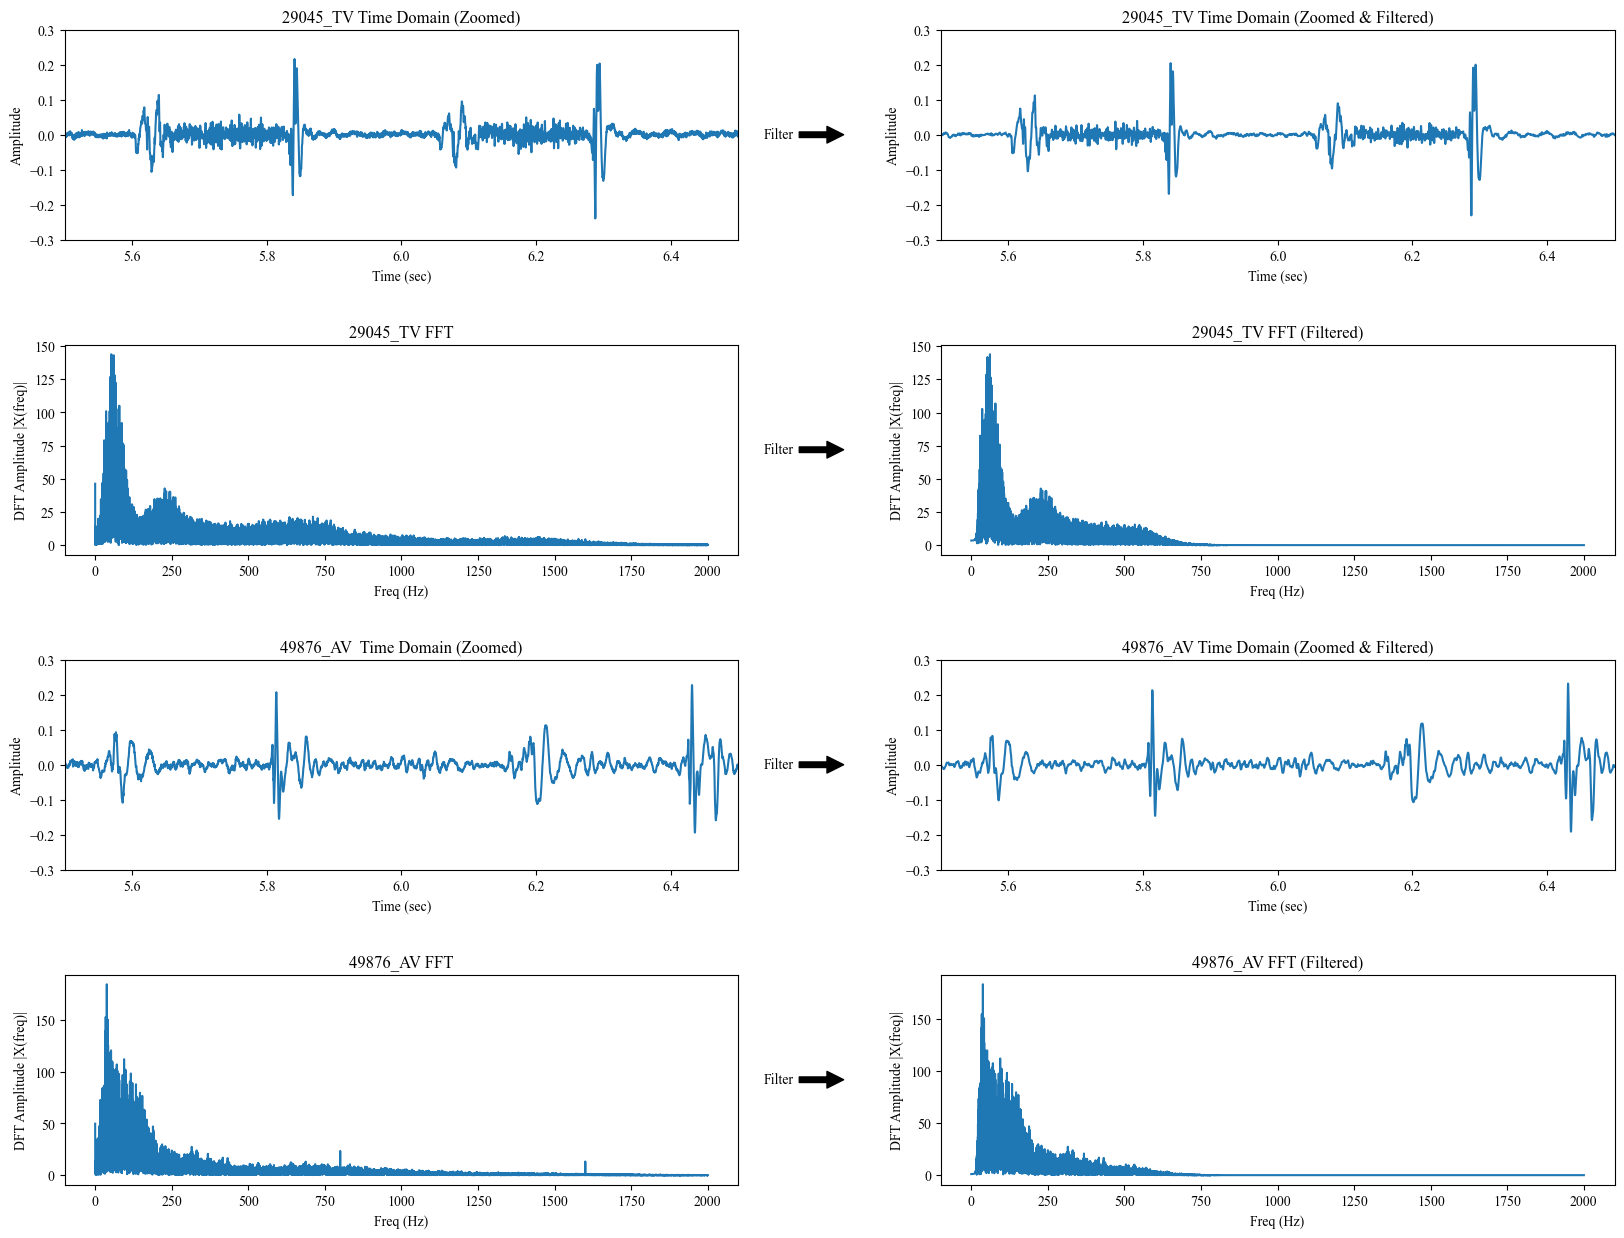

In [5]:
# Definition of filter functions:
def butter_highpass_filter(data, cutoff, fs, order):
    nyq = fs * 0.5
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype='high', analog=False,output='sos')
    y = sosfiltfilt(sos, data) # second filter approach to do forward and backward pass of filter to remove lag

    return y

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = fs * 0.5
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype='low', analog=False,output='sos')
    y = sosfiltfilt(sos, data)

    return y

def butter_bandpass_filter(data, low_cutoff, high_cutoff, fs, order):
    nyq = fs * 0.5
    normal_cutoff_low = low_cutoff / nyq
    normal_cutoff_high = high_cutoff / nyq
    sos = butter(order, [normal_cutoff_low,normal_cutoff_high], btype='band', analog=False, output='sos')
    y = sosfiltfilt(sos, data)

    return y


# Step 1: Filter frequencies
low_cutoff = 20 # 200 for cutting off main parts of hb (allows interesting comparison of files, effectively trying to highlight the murmur)
high_cutoff = 600

TV_signal_filtered = butter_bandpass_filter(TV_signal, low_cutoff, high_cutoff, TV_sr, 6)
AV_signal_filtered = butter_bandpass_filter(AV_signal, low_cutoff, high_cutoff, AV_sr, 6)

# Step 2: Plot graphs
# plot for both files
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

xlim_time = (5.5,6.5)
ylim_time = (-0.3, 0.3)

xlim_fft = None # (max(0,low_cutoff-50), high_cutoff+100) # show x-axis only for relevant frequencies incl. a margin

# draw arrow for visual representation of filter process
annotation_props = dict(
    xytext=(-0.24, 0.5),
    xy=(-0.14, 0.5),
    xycoords='axes fraction',
    textcoords='axes fraction',
    arrowprops=dict(facecolor='black', shrink=0.05),
    horizontalalignment='center',
    verticalalignment='center'
)

# non-filtered: first column, filtered: second column
# 29045_TV plots (first two rows)
plot_time_domain(TV_signal, TV_time, '29045_TV Time Domain (Zoomed)', row=4, col=2, index=1, xlim=xlim_time, ylim=ylim_time) # unfiltered
plot_time_domain(TV_signal_filtered, TV_time, '29045_TV Time Domain (Zoomed & Filtered)', row=4, col=2, index=2, xlim=xlim_time, ylim=ylim_time) # filtered
plt.annotate('Filter', **annotation_props)


plot_frequency_domain(TV_signal, TV_sr, '29045_TV FFT', row=4, col=2, index=3, xlim=xlim_fft, ylim=None) # unfiltered
plot_frequency_domain(TV_signal_filtered, TV_sr, '29045_TV FFT (Filtered)', row=4, col=2, index=4, xlim=xlim_fft, ylim=None) # filtered
plt.annotate('Filter', **annotation_props)

# 49876_AV plots (second two rows)
plot_time_domain(AV_signal, AV_time, '49876_AV  Time Domain (Zoomed)', row=4, col=2, index=5, xlim=xlim_time, ylim=ylim_time) # unfiltered
plot_time_domain(AV_signal_filtered, AV_time, '49876_AV Time Domain (Zoomed & Filtered)', row=4, col=2, index=6, xlim=xlim_time, ylim=ylim_time) # filtered
plt.annotate('Filter', **annotation_props)

plot_frequency_domain(AV_signal, AV_sr, '49876_AV FFT', row=4, col=2, index=7, xlim=xlim_fft, ylim=None) # unfiltered
plot_frequency_domain(AV_signal_filtered, AV_sr, '49876_AV FFT (Filtered)', row=4, col=2, index=8, xlim=xlim_fft, ylim=None) # filtered
plt.annotate('Filter', **annotation_props)

plt.show()

**Task 1.5**: Now load the files in the Task_1_5 folder. Again, there is one instance of murmur and one instance of non-murmur. Perform the same analysis as above and see if you can still differentiate between the two by inspection.

---

❓ Discuss whether you can differentiate between the signals or not and if not, why not.

In [6]:
#AV_29045_signal, AV_29045_sr = librosa.load('/content/drive/MyDrive/Cambridge/Studies/Lent/MobileHealth/Assessment1/mobile-health-assignment-1/task_1_5/29045_AV.wav', sr=None)
#AV_39043_signal, AV_39043_sr = librosa.load('/content/drive/MyDrive/Cambridge/Studies/Lent/MobileHealth/Assessment1/mobile-health-assignment-1/task_1_5/39043_AV.wav', sr=None)

AV_29045_signal, AV_29045_sr = librosa.load('data/mobile-health-assignment-1/task_1_5/29045_AV.wav', sr=None)
AV_39043_signal, AV_39043_sr = librosa.load('data/mobile-health-assignment-1/task_1_5/39043_AV.wav', sr=None)

print(f'Data loaded successfully. 29045_AV SR: {AV_29045_sr}, 39043_AV SR: {AV_39043_sr}')

Data loaded successfully. 29045_AV SR: 4000, 39043_AV SR: 4000


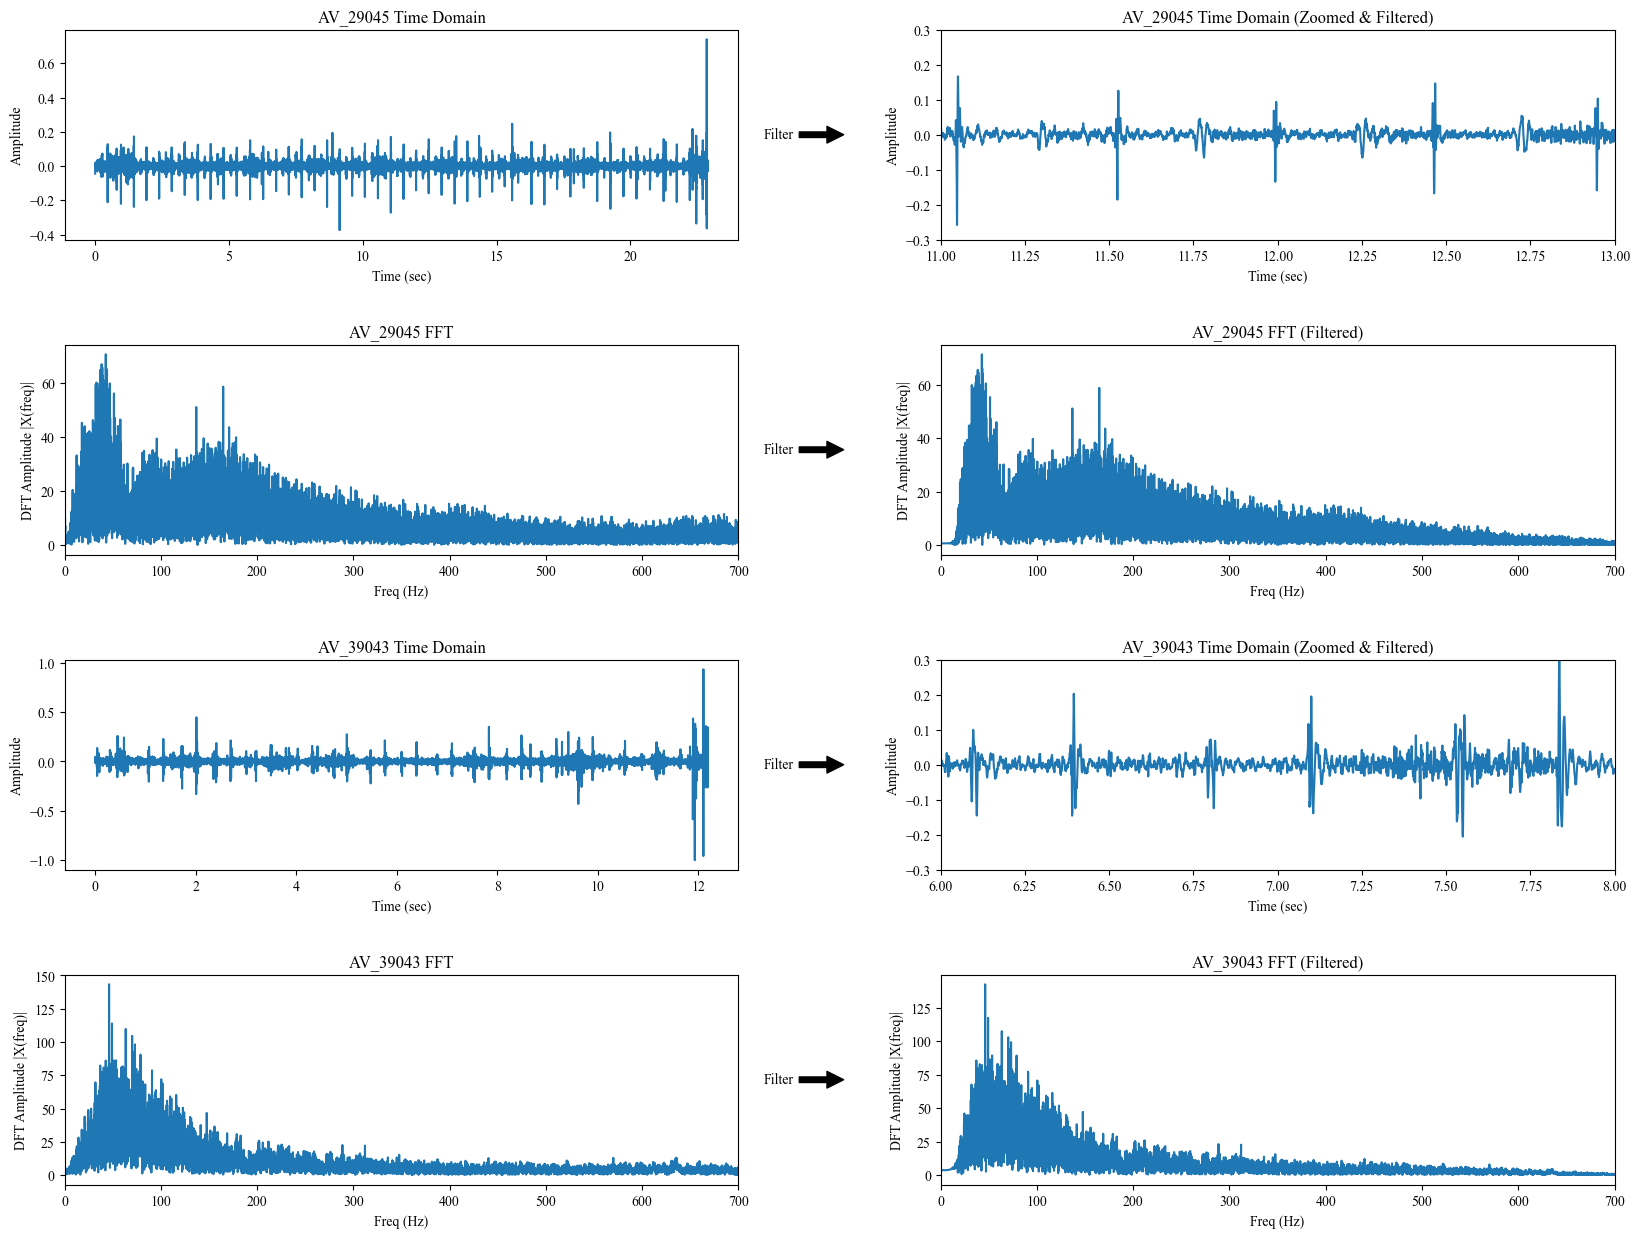

In [7]:
# get time
AV_29045_time = np.linspace(0, len(AV_29045_signal) / AV_29045_sr, num=len(AV_29045_signal))
AV_39043_time = np.linspace(0, len(AV_39043_signal) / AV_39043_sr, num=len(AV_39043_signal))

# filter signals
AV_29045_signal_filtered = butter_bandpass_filter(AV_29045_signal, low_cutoff, high_cutoff, AV_29045_sr, 4)
AV_39043_signal_filtered = butter_bandpass_filter(AV_39043_signal, low_cutoff, high_cutoff, AV_39043_sr, 4)

# plot for both files
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

xlim_time1 = (11,13)
xlim_time2 = (6,8)

ylim_time1 = (-0.3, 0.3)
ylim_time2 = (-0.3, 0.3)

xlim_fft = (max(0,low_cutoff-50), high_cutoff+100) # show x-axis only for relevant frequencies incl. a margin


# non-filtered: first column, filtered: second column
# AV_29045 plots (first two rows)
plot_time_domain(AV_29045_signal, AV_29045_time, 'AV_29045 Time Domain', row=4, col=2, index=1, xlim=None, ylim=None) # unfiltered
plot_time_domain(AV_29045_signal_filtered, AV_29045_time, 'AV_29045 Time Domain (Zoomed & Filtered)', row=4, col=2, index=2, xlim=xlim_time1, ylim=ylim_time1) # filtered
plt.annotate('Filter', **annotation_props)


plot_frequency_domain(AV_29045_signal, AV_29045_sr, 'AV_29045 FFT', row=4, col=2, index=3, xlim=xlim_fft, ylim=None) # unfiltered
plot_frequency_domain(AV_29045_signal_filtered, AV_29045_sr, 'AV_29045 FFT (Filtered)', row=4, col=2, index=4, xlim=xlim_fft, ylim=None) # filtered
plt.annotate('Filter', **annotation_props)

# AV_39043 plots (second two rows)
plot_time_domain(AV_39043_signal, AV_39043_time , 'AV_39043 Time Domain', row=4, col=2, index=5, xlim=None, ylim=None) # unfiltered
plot_time_domain(AV_39043_signal_filtered, AV_39043_time , 'AV_39043 Time Domain (Zoomed & Filtered)', row=4, col=2, index=6, xlim=xlim_time2, ylim=ylim_time2) # filtered
plt.annotate('Filter', **annotation_props)

plot_frequency_domain(AV_39043_signal, AV_39043_sr, 'AV_39043 FFT', row=4, col=2, index=7, xlim=xlim_fft, ylim=None) # unfiltered
plot_frequency_domain(AV_39043_signal_filtered, AV_39043_sr, 'AV_39043 FFT (Filtered)', row=4, col=2, index=8, xlim=xlim_fft, ylim=None) # filtered
plt.annotate('Filter', **annotation_props)

plt.show()

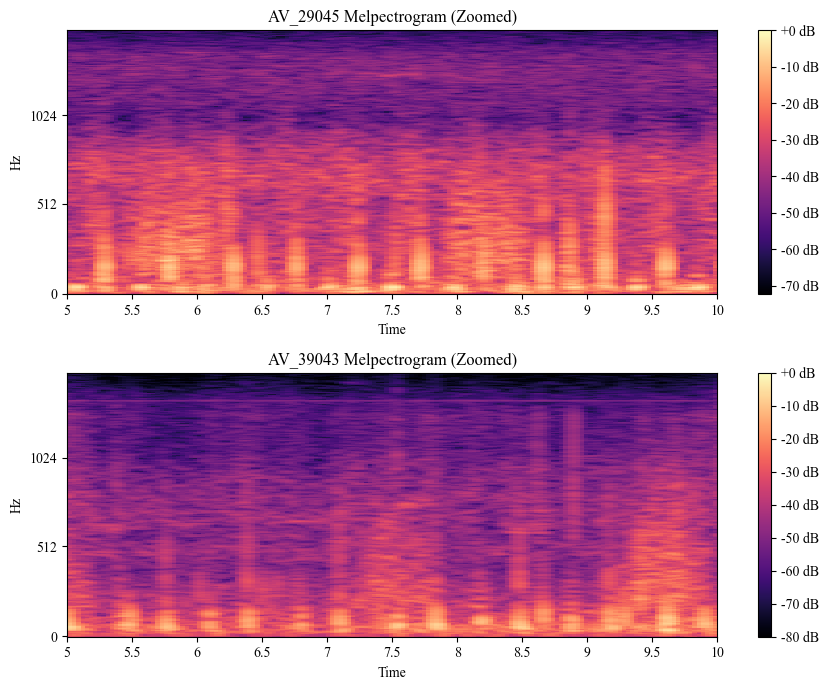

In [8]:
# Plot melspectograms:
plt.figure(figsize=(9, 7))

plt.subplots_adjust(hspace=0.5, wspace=0.3)

plot_melspectrogram(AV_29045_signal, AV_29045_sr, 'AV_29045 Melpectrogram (Zoomed)', row=2, col=1, index=1, xlim=(5, 10), n_fft=1024, hop_length=128, n_mels=256)
plot_melspectrogram(AV_39043_signal, AV_39043_sr, 'AV_39043 Melpectrogram (Zoomed)', row=2, col=1, index=2, xlim=(5, 10), n_fft=1024, hop_length=128, n_mels=256)

plt.show()

As you can see, it's now difficult to diagnose the murmur visually. It is for this reason that we use machine learning for classification in the audio field.

## Part 2: Dataset processing [15 marks]

**Task 2.1:** Loading the dataset metadata

The dataset that you will be working with is a subset of dataset released as a part of [PhysioNet 2022 challenge](https://moody-challenge.physionet.org/2022/).

Please note, we kept the murmur and normal classes, removed the unknown class, and removed any patients that has low sample quality or had less than 2 samples available per patient.

In [9]:
# load the metadata (replace None with the appropriate code)
#metadata_train = pd.read_csv('/content/drive/MyDrive/Cambridge/Studies/Lent/MobileHealth/Assessment1/mobile-health-assignment-1/provided_metadata_train.csv')
#metadata_test = pd.read_csv('/content/drive/MyDrive/Cambridge/Studies/Lent/MobileHealth/Assessment1/mobile-health-assignment-1/provided_metadata_test.csv')

metadata_train = pd.read_csv('data/mobile-health-assignment-1/provided_metadata_train.csv')
metadata_test = pd.read_csv('data/mobile-health-assignment-1/provided_metadata_test.csv')
metadata = metadata_train # pd.concat([metadata_train, metadata_test], ignore_index = True) (in case one would like to analyse the full set)
pd.set_option('display.max_columns', None) # show all columns
metadata

,Patient ID,Recording locations:,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,Systolic murmur timing,Systolic murmur shape,Systolic murmur grading,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,49897,AV+PV+TV+MV,Child,Male,115.0,17.1,False,Present,AV+MV+PV+TV,PV,Mid-systolic,Diamond,III/VI,Medium,Harsh,NaN,NaN,NaN,NaN,NaN,Normal,CC2014,68194.0
1,84874,AV+PV+TV+MV,Child,Male,155.0,46.8,False,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2015,NaN
2,84753,AV+PV+TV+MV,Child,Male,123.0,19.6,False,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2015,NaN
3,69188,AV+PV+TV+MV,Child,Male,92.0,15.6,False,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,84834,AV+PV+TV+MV,Infant,Female,71.0,8.6,False,Present,AV+MV+PV+TV,TV,Holosystolic,Plateau,III/VI,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,13918,AV+PV+TV+MV,Child,Male,98.0,15.9,False,Present,TV,TV,Holosystolic,Plateau,I/VI,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
187,84735,AV+PV+TV+MV,Child,Female,115.0,15.7,False,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2015,NaN
188,50225,AV+PV+TV+MV,Child,Female,131.0,34.8,False,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2014,NaN
189,85133,AV+PV+TV+MV,Child,Female,149.0,33.9,False,Present,AV+MV+PV+TV,TV,Holosystolic,Plateau,III/VI,Medium,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN


In [10]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Patient ID                191 non-null    int64  
 1   Recording locations:      191 non-null    object 
 2   Age                       180 non-null    object 
 3   Sex                       191 non-null    object 
 4   Height                    173 non-null    float64
 5   Weight                    174 non-null    float64
 6   Pregnancy status          191 non-null    bool   
 7   Murmur                    191 non-null    object 
 8   Murmur locations          56 non-null     object 
 9   Most audible location     56 non-null     object 
 10  Systolic murmur timing    56 non-null     object 
 11  Systolic murmur shape     56 non-null     object 
 12  Systolic murmur grading   56 non-null     object 
 13  Systolic murmur pitch     56 non-null     object 
 14  Systolic m

**Task 2.2: Analysing the classes and demographics**


Hint: you could achieve this by using the following pandas methods:
- [`groupby`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)
- [`count`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.count.html)
- [`plot`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

---

❓What is the ratio of normal to murmur patients? And what is the ratio of normal to murmur samples? Can you think of any implications of this?

❓Prepare some graphs representing basic demographic split across classes, such as sex, age, etc. Make sure you use the correct type of graph for your data to display the information intuitively.

❓What significance does the demographic split carry in datasets used for ML?

In [11]:
# Question 1: What is the ratio of normal to murmur patients? And what is the ratio of normal to murmur samples? Can you think of any implications of this?

# Double-check vlaues in column 'murmur': metadata['Murmur'].unique() --> yields ['Present', 'Absent'] --> can be used to distinguish between murmur and normal!

# number of patients with Murmur 'Absent' vs 'Present' (patient equals entry in dataframe)
murmur_patient_counts = metadata.groupby('Murmur').size()

# assumed samples can be obtained by splitting the 'Recording locations:' & 'Murmur locations', similar to the tasks that follow
# total samples
total_samples = 0
for locations in metadata['Recording locations:']:
    total_samples += len(locations.split('+'))

# murmur samples
murmur_samples = 0
for locations in metadata.dropna(subset=['Murmur locations'])['Murmur locations']:
    murmur_samples += len(locations.split('+'))
# normal samples
normal_samples = total_samples - murmur_samples

# ratios:
normal_to_murmur_patient_ratio = murmur_patient_counts['Absent'] / murmur_patient_counts['Present']
normal_to_murmur_sample_ratio = normal_samples / murmur_samples

print(f"Normal (#{murmur_patient_counts['Absent']}) to Murmur (#{murmur_patient_counts['Present']}) Patient Ratio: {round(normal_to_murmur_patient_ratio,2)}")
print(f"Normal (#{normal_samples}) to Murmur (#{murmur_samples}) Sample Ratio: {round(normal_to_murmur_sample_ratio, 2)}")

Normal (#135) to Murmur (#56) Patient Ratio: 2.41
Normal (#584) to Murmur (#180) Sample Ratio: 3.24


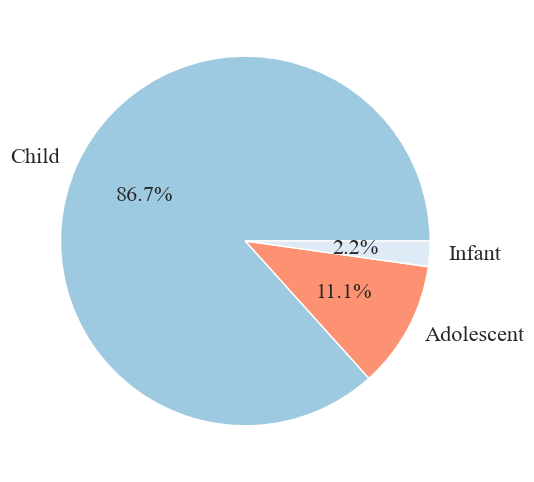

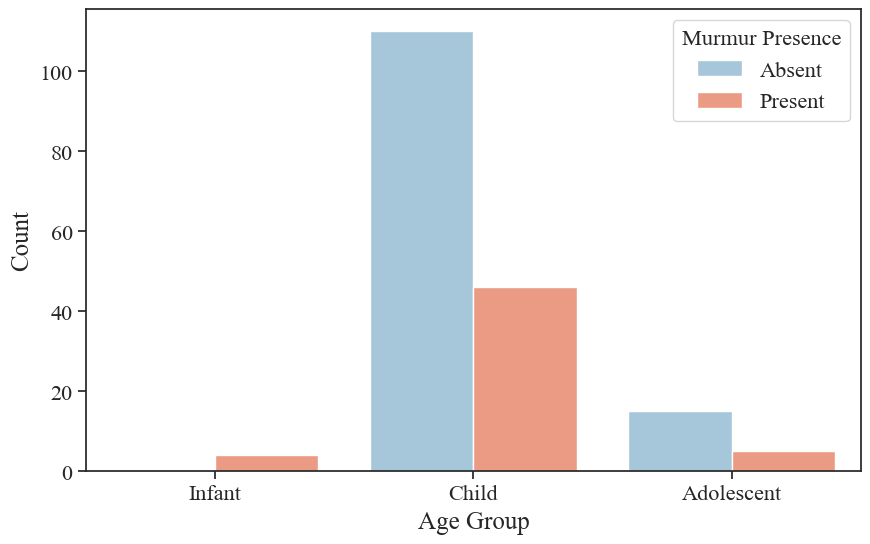

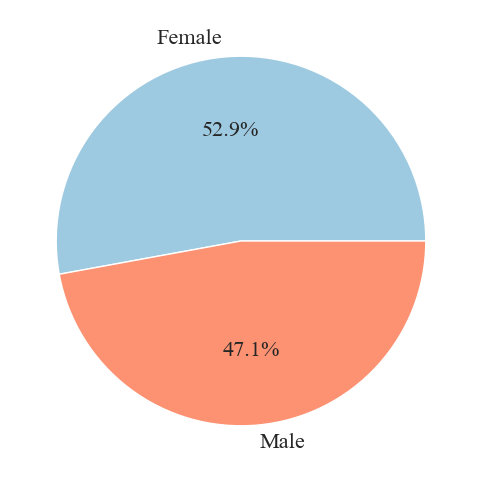

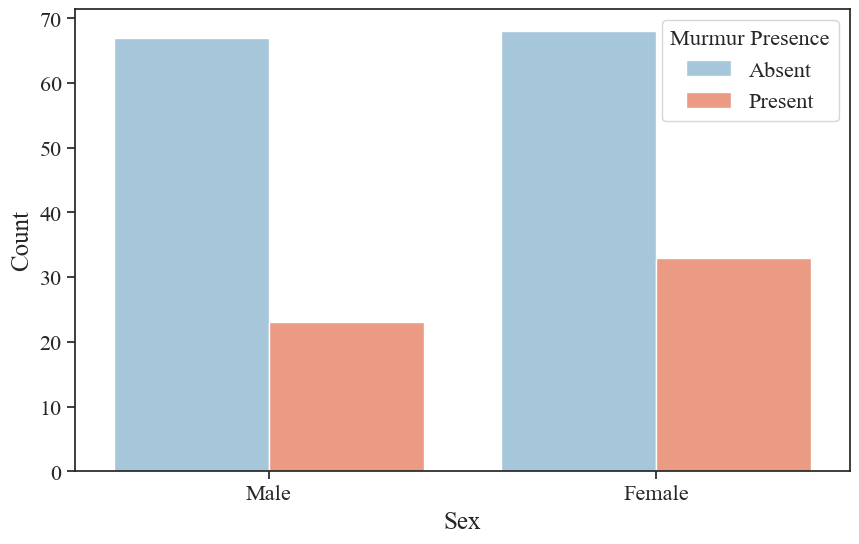

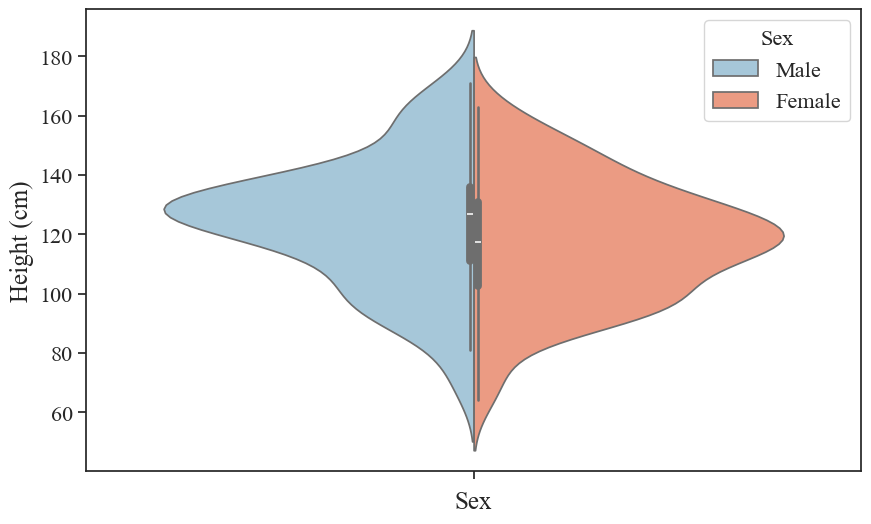

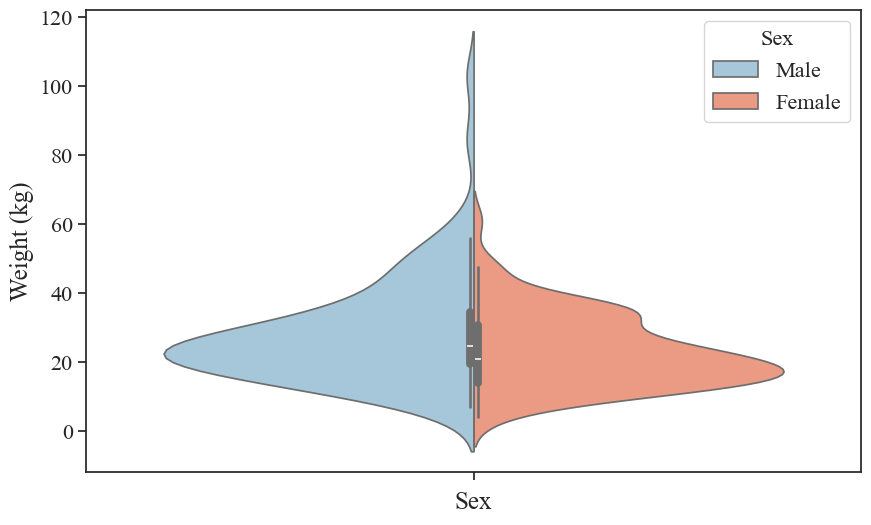

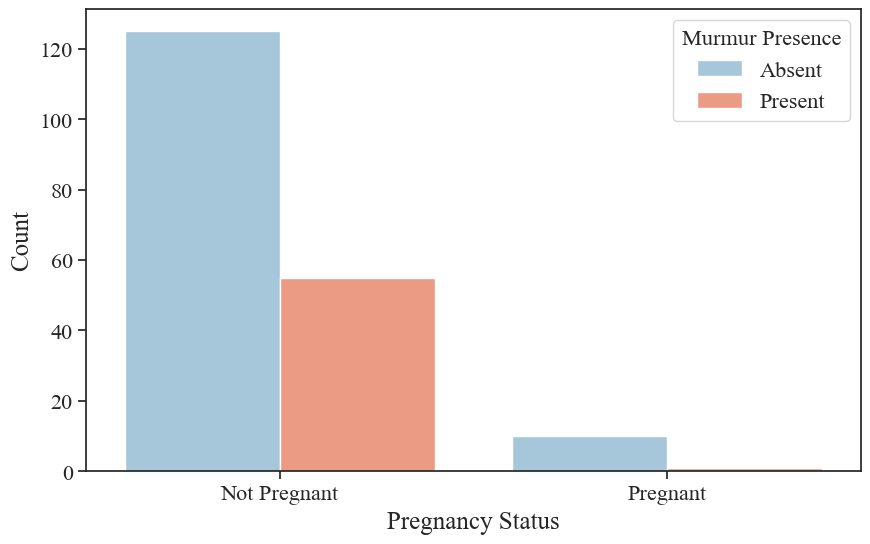

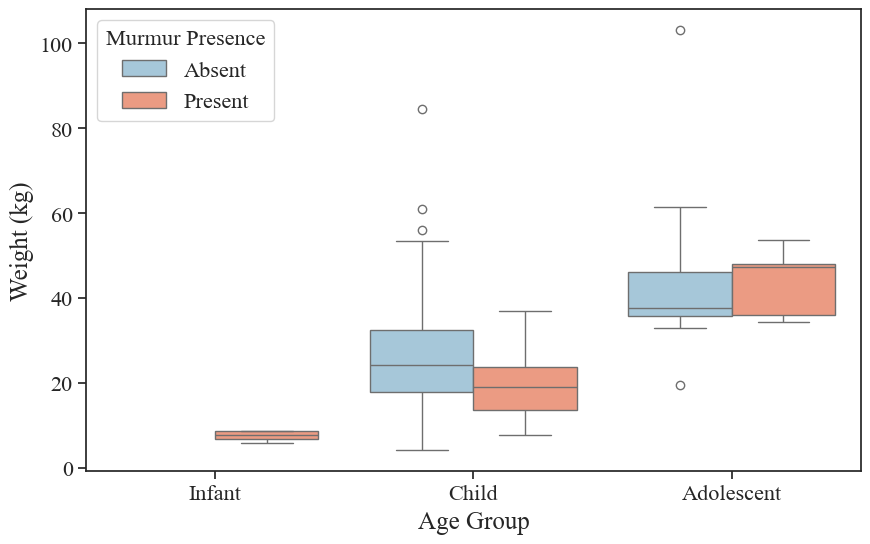

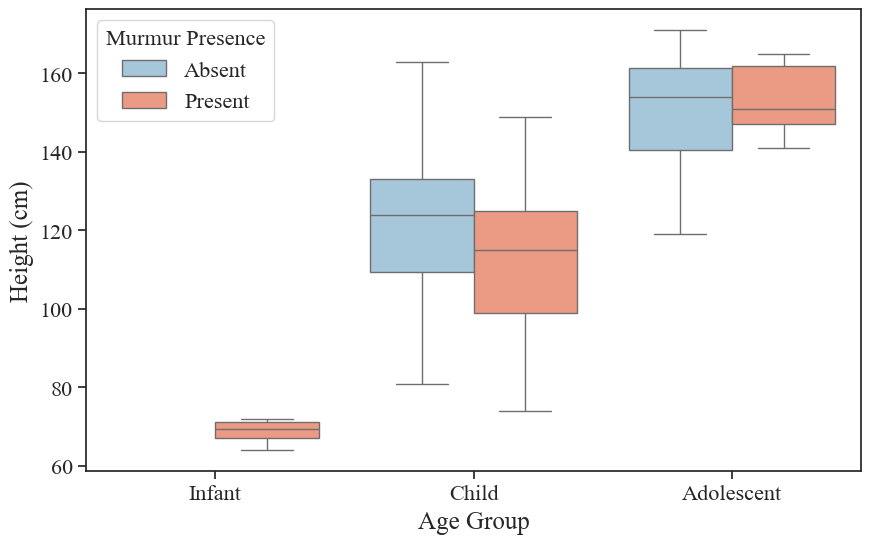

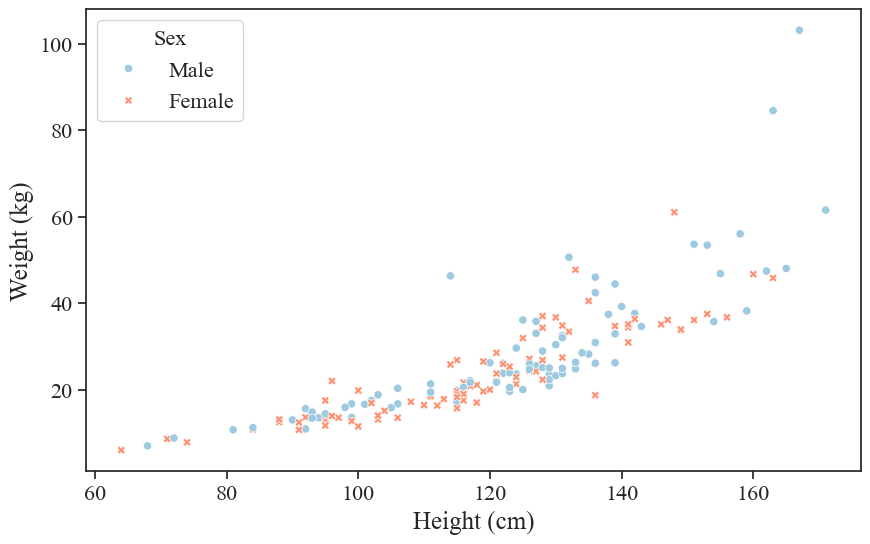

In [12]:
#Question 2: Prepare some graphs representing basic demographic split across classes, such as sex, age, etc. Make sure you use the correct type of graph for your data to display the information intuitively.

# set style, fontsize, order of values, colours for nicer plots
sns.set(style='ticks', palette='muted')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.title_fontsize'] = 16
plt.rcParams['legend.fontsize'] = 16

age_order = ['Infant', 'Child', 'Adolescent']
murmur_palette = {'Absent': '#9ecae1', 'Present': '#fc9272'}
sex_palette = {'Male': '#9ecae1', 'Female': '#fc9272'}
hue_order = ['Absent', 'Present']
pie_colors = ['#9ecae1', '#fc9272', '#deebf7'] 

# Age pie
age_distribution = metadata['Age'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(age_distribution, labels=age_distribution.index, autopct='%1.1f%%', colors=pie_colors, textprops={'fontsize': 16}, shadow=False)
# plt.title('Age Group Distribution')
plt.savefig('Images/Task2/age_pie.png', dpi=300, bbox_inches='tight')
plt.show()


# Age bar
age_murmur_counts = metadata.groupby(['Age', 'Murmur']).size().reset_index(name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(x='Age', y='Count', hue='Murmur', data=age_murmur_counts, order=age_order, palette=murmur_palette, hue_order=hue_order)
#plt.title('Age Distribution of Patients with and without Murmur')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Murmur Presence')
plt.savefig('Images/Task2/age_murmur.png', dpi=300, bbox_inches='tight')
plt.show()

# Sex pie
sex_distribution = metadata['Sex'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(sex_distribution, labels=sex_distribution.index, autopct='%1.1f%%', colors=pie_colors, textprops={'fontsize': 16}, shadow=False)
# plt.title('Sex Distribution')
plt.savefig('Images/Task2/sex_pie.png', dpi=300, bbox_inches='tight')
plt.show()

# Sex
plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Murmur', data=metadata, dodge=True, palette=murmur_palette, hue_order=hue_order)
#plt.title('Sex Distribution of Patients with and without Murmur')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Murmur Presence')
plt.savefig('Images/Task2/sex_murmur.png', dpi=300, bbox_inches='tight')
plt.show()

# Height by sex
plt.figure(figsize=(10, 6))
sns.violinplot(hue='Sex', y='Height', data=metadata, inner='box', split=True, fill=True, palette=sex_palette)
#plt.title('Height Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Height (cm)')
plt.savefig('Images/Task2/height_sex.png', dpi=300, bbox_inches='tight')
plt.show()

# Weight by sex
plt.figure(figsize=(10, 6))
sns.violinplot(hue='Sex', y='Weight', data=metadata, inner='box', split=True, fill=True, palette=sex_palette)
#plt.title('Weight Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Weight (kg)')
plt.savefig('Images/Task2/weight_sex.png', dpi=300, bbox_inches='tight')
plt.show()

# Pregnancy
plt.figure(figsize=(10, 6))
sns.countplot(x='Pregnancy status', hue='Murmur', data=metadata, palette=murmur_palette, hue_order=hue_order)
#plt.title('Pregnancy Status Distribution')
plt.xlabel('Pregnancy Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Pregnant', 'Pregnant'])
plt.legend(title='Murmur Presence')
plt.savefig('Images/Task2/pregnancy_murmur.png', dpi=300, bbox_inches='tight')
plt.show()

# Weight across age groups
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age', y='Weight', hue='Murmur', data=metadata, order=age_order, palette=murmur_palette, hue_order=hue_order)
#plt.title('Weight Distribution Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Weight (kg)')
plt.legend(title='Murmur Presence')
plt.savefig('Images/Task2/weight_age.png', dpi=300, bbox_inches='tight')
plt.show()

# Height across age groups
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age', y='Height', hue='Murmur', data=metadata, order=age_order, palette=murmur_palette, hue_order=hue_order)
#plt.title('Weight Distribution Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Height (cm)')
plt.legend(title='Murmur Presence')
plt.savefig('Images/Task2/height_age.png', dpi=300, bbox_inches='tight')
plt.show()

# Height and weight
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Height', y='Weight', hue='Sex', data=metadata, style='Sex', palette=sex_palette)
#plt.title('Height vs. Weight Scatter Plot')
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.legend(title='Sex')
plt.savefig('Images/Task2/weight_height.png', dpi=300, bbox_inches='tight')
plt.show()

**Task 2.3: Dataset processing**

As mentioned previously, in the case of mild murmurs, even if a patient has a diseased valve, the murmur may only be present in certain locations on the chest, while the sound would appear normal in other locations.

The metadata provides the details about each individual patient, inlcuding their overall murmur diagnosis, as well as which locations contain the murmurs. Since the provided metadata includes information on a per patient basis, **you have to transform it to provide information on a per file basis**.

For example, if the given metadata file looks similar to this:

Patient ID | Recording locations | Murmur | Murmur locations
:-:|:-:|:-: |:-:
**1234**| AV + MV + TV | 0 | -
**5678**| AV + MV + TV | 1 | AV + MV

You want to create a new metadata table, which would look like this:

 Patient ID | File name| Murmur per file | Murmur per patient
:-:|:-:|:-: |:-:
**1234**| 1234_AV.wav | 0 | 0
**1234**| 1234_MV.wav | 0 | 0
**1234**| 1234_TV.wav | 0 | 0
**5678**| 5678_AV.wav | 1 | 1
**5678**| 5678_MV.wav | 1 | 1
**5678**| 5678_TV.wav | 0 | 1

To help you, we have written most of the code, but purposefully left it incomplete, leaving it up to you to finish it.

In [26]:
def isNan(num):
    return num!= num

all_locations_list = []
all_murmur_locations_list = []

# we iterate through all the patients in the original metadata dataframe
for index, row in metadata.iterrows():

  location_string = str(row["Recording locations:"])
  murmur_location_string = str(row["Murmur locations"])

  # we split the locations string (e.g. "AV+MV+TV+PV") into individual
  # locations and store them in a list (e.g. [AV, MV, TV, PV]) so that we can
  # easily iterate through them.
  location_list = location_string.split("+")
  all_locations_list.append(location_list)

  # If this patient has no murmur, we save it as such for all files
  # belonging to this one patient. Otherwise, we need to split the string of
  # murmur locations into the list. That's the part that you need to do.
  if isNan(murmur_location_string):
    all_murmur_locations_list.append(float(murmur_location_string))

  else:

    ######################################################################
    # Replace None to split the murmur locations into list
    ######################################################################

    murmur_location_list = murmur_location_string.split("+")

    all_murmur_locations_list.append(murmur_location_list)

    ######################################################################

"""
we create a new metadata dataframe that stores recording and murmur locations
in a list, meaning that we can easily iterate through it to create a new DF
You can analyse the result by uncommenting the last line.
"""

metadata_df = metadata
metadata_df["Recording locations:"] = all_locations_list
metadata_df["Murmur locations"] = all_murmur_locations_list

# metadata_df.head()

In [14]:
### You do not need to edit this cell ###
"""
we need to have a list of all the filenames that we expect to encounter in
the training files folder. Given we are familiar with the file naming structure,
we use the fact that each file is <PATIENT_ID>_<LOCATION>.wav.
"""

def create_list_with_filenames(dataframe):
  filename_list = []

  # we iterate through all the patients
  for _, row in dataframe.iterrows():
    patient_id = str(row["Patient ID"])
    location_list = row["Recording locations:"]
    filename_list_for_specific_patient = []

    # we iterate through all the locations that the patient has recordings in,
    # that are now stored in a list, to create the filenames that we expect
    for location in location_list:
      filename = str(patient_id + "_" + location + ".wav")
      filename_list_for_specific_patient.append(filename)

    filename_list.append(filename_list_for_specific_patient)

  return filename_list

"""
we add a new column to our dataframe that contains a list with all of the WAV
files belonging to a single patient of interest. You can analyse the result by
uncommenting the last line.
"""
filename_list = create_list_with_filenames(metadata_df)
metadata_df["Filenames"] = filename_list

# metadata_df.head()

In [15]:
def extract_murmur_status(murmur, murmur_locations, filename):

  if murmur == "Absent":
    murmur_status_per_file = 0
    murmur_status_per_patient = 0

  elif murmur == "Present":
    murmur_status_per_patient = 1

    ######################################################################
    # Replace None to extract the recording location from the filename
    # Hint: use the knowledge of the file naming and the fact that
    # location is always represented by two letters.
    ######################################################################

    file_location = filename.split("_")[-1][:2] # split of last part (i.e. "<location>.wav" and take first two letters)

    ######################################################################

    for murmur_location in murmur_locations:
      if file_location == murmur_location:
          murmur_status_per_file = 1
          break

      else:
          murmur_status_per_file = 0

  return murmur_status_per_file, murmur_status_per_patient

In [16]:
filenames_list_for_df = []
patient_id_list_for_df = []
murmur_per_file_for_df = []
murmur_per_patient_for_df = []

for index, row in metadata_df.iterrows():

  ######################################################################
  # Replace None to extract information from metadata about the patient
  ######################################################################

  filenames = row['Filenames']
  patient_id = row['Patient ID']
  murmur_locations = row['Murmur locations']
  murmur = row['Murmur']

  ######################################################################

  # we iterate through the filenames to populate new lists of data
  # for the new per-file dataframe
  for filename in filenames:

    filenames_list_for_df.append(filename)
    patient_id_list_for_df.append(patient_id)
    murmur_status_per_file, murmur_status_per_patient = extract_murmur_status(murmur,
                                                                              murmur_locations,
                                                                              filename)
    murmur_per_file_for_df.append(murmur_status_per_file)
    murmur_per_patient_for_df.append(murmur_status_per_patient)


In [17]:
### You do not need to edit this cell ###

new_metadata_dataframe = pd.DataFrame(list(zip(filenames_list_for_df, patient_id_list_for_df,
                                               murmur_per_file_for_df, murmur_per_patient_for_df)),
                                               columns = ["filename", "patient_id", "murmur_per_file", "murmur_per_patient"])

# Uncomment the last line if you would like to see the resulting dataframe
new_metadata_dataframe.head()

,filename,patient_id,murmur_per_file,murmur_per_patient
0,49897_AV.wav,49897,1,1
1,49897_PV.wav,49897,1,1
2,49897_TV.wav,49897,1,1
3,49897_MV.wav,49897,1,1
4,84874_AV.wav,84874,0,0


**Task 2.4**: Given your analysis of the dataset in Task 2.2, it is apparent that the dataset is heavily imbalanced. Address the imbalance by the method of your choice, for example by upsampling the minority class or downsampling the majority class.

Hint: you might want to use [**resample**](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html).

---

❓ What is the effect of tackling the imbalance on the resulting classification performance? Give results to compare different methods of tackling imbalance.

In [18]:
from sklearn.utils import resample

# Cutting dataframe into classes based on findings from Task 2.2
# --> majority class = normal/healthy individuals (as normal to murmur samples ratio is 3.24)
# --> minority class = individuals with murmurs
df_majority = new_metadata_dataframe[new_metadata_dataframe['murmur_per_file'] == 0]
df_minority = new_metadata_dataframe[new_metadata_dataframe['murmur_per_file'] == 1]

# Option 1: Upsampling the minority class
df_minority_upsampled = resample(df_minority
                                 , replace=True                 # replace=True as we have to upsample and thus need to use some samples more than once
                                 , n_samples=len(df_majority)   # n_samples to match majority class
                                 , random_state=42)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])  # re-assemble df

# Option 2: Downsampling the majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,               #  replace=False as we have to downsample and thus do not need to use some samples more than once
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state=42)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority]) # re-assemble df


new_metadata_dataframe = df_downsampled

## Part 3: Feature extraction [30 marks]

We will now extract features from the Physionet dataset that will be used to classify samples with murmurs.

Please note that for this part you are not expected to use normalisation at all, since we the already included normalisation for you in the processing pipeline within the training / testing function.



**Task 3.1:** Complete a function to extract [librosa](https://librosa.org/doc/main/feature.html) features of your choice from the dataset. You might want to concatenate them in order to form a feature vector.

We have already started the function for you and are extracting Mel frequency cepstral coefficients (MFCCs), a feature commonly used for classification in audio space. Add additional features to the function accordingly.

---

❓ Which features did you choose and why? Use literature and/or performance assessments to inform your decisions.

❓ What parameters have you chosen for the features that you extracted (e.g. hop length, window size, etc.) and why?

In [ ]:
def extract_librosa_features(audio_signal, sr):
  feature_vector = []

  ######################################################################
  # Edit this part of the code to extract the features of your choice
  ######################################################################

  # MFCCs
  mfcc = np.mean(librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=40), axis=1)
  feature_vector.extend(mfcc.tolist())

  # Zero Crossing Rate
  zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio_signal)) # chakir
  feature_vector.append(zero_crossing_rate) 

  # Chroma STFT
  chroma = np.mean(librosa.feature.chroma_stft(y=audio_signal, sr=sr), axis=1) #tariq
  feature_vector.extend(chroma.tolist())  

  # Spectral Centroid
  spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio_signal, sr=sr), axis=1)
  feature_vector.extend(spectral_centroid.tolist())

  # Spectral Bandwidth
  spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio_signal, sr=sr), axis=1)
  feature_vector.extend(spectral_bandwidth.tolist())

  # Spectral Contrast
  spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio_signal, sr=sr, fmin=50, n_bands=6), axis=1) # fmin = frequency cutoff for the first bin, see Spencer and Pennington --> focus on S1 & S2 and critical heartbeat
  feature_vector.extend(spectral_contrast.tolist())

  # RMS Energy
  rms_energy = np.mean(librosa.feature.rms(y=audio_signal), axis=1)
  feature_vector.extend(rms_energy.tolist())


  ######################################################################

  return feature_vector

#### Adaption of the above cell to be able to test different feature extraction configurations
- Instead of hard-coding features: allow to define features once and then choose the desired combinations of features and parameters using a "config" dict

In [19]:
def extract_librosa_features_config(audio_signal, sr, config):
    feature_dict = {}

    # helper function to add features to the dict
    def add_feature(name, features, index=None):
        if index is not None:
            # add features with index in case of multiple values per feature!
            for i, feature in enumerate(features):
                feature_dict[f"{name}+{i}"] = feature
        else:
            feature_dict[name] = features[0] if isinstance(features, list) else features

    # MFCCs
    if 'mfcc' in config:
        mfcc_config = config['mfcc']
        mfcc = librosa.feature.mfcc(y=audio_signal, sr=sr, 
                                    n_mfcc=mfcc_config.get('n_mfcc', 19),
                                    n_fft=mfcc_config.get('n_fft', 256),
                                    hop_length=mfcc_config.get('hop_length', 128)).mean(axis=1)
        add_feature('mfcc', mfcc, index=True)

    # Zero Crossing Rate
    if 'zero_crossing_rate' in config:
        zcr = [np.mean(librosa.feature.zero_crossing_rate(y=audio_signal,
                                                          hop_length=config.get('hop_length', 128)))]
        add_feature('zero_crossing_rate', zcr)

    # Chroma STFT
    if 'chroma' in config:
        chroma_config = config['chroma']
        chroma = librosa.feature.chroma_stft(y=audio_signal, sr=sr, 
                                             n_chroma=chroma_config.get('n_chroma', 24),
                                             hop_length=chroma_config.get('hop_length', 128)).mean(axis=1)
        add_feature('chroma', chroma, index=True)

    # Spectral Centroid
    if 'spectral_centroid' in config:
        centroid = [np.mean(librosa.feature.spectral_centroid(y=audio_signal, sr=sr, 
                                                              hop_length=config.get('hop_length', 128)))]
        add_feature('spectral_centroid', centroid)

    # Spectral Bandwidth
    if 'spectral_bandwidth' in config:
        bandwidth = [np.mean(librosa.feature.spectral_bandwidth(y=audio_signal, sr=sr, 
                                                                hop_length=config.get('hop_length', 128)))]
        add_feature('spectral_bandwidth', bandwidth)

    # Spectral Contrast
    if 'spectral_contrast' in config:
        contrast_config = config['spectral_contrast']
        contrast = librosa.feature.spectral_contrast(y=audio_signal, sr=sr, 
                                                     fmin=contrast_config.get('fmin', 50), 
                                                     n_bands=contrast_config.get('n_bands', 3),
                                                     hop_length=contrast_config.get('hop_length', 128)).mean(axis=1)
        add_feature('spectral_contrast', contrast, index=True)

    # RMS Energy
    if 'rms' in config:
        rms = [np.mean(librosa.feature.rms(y=audio_signal, 
                                           hop_length=config.get('hop_length', 128)))]
        add_feature('rms', rms)


    return feature_dict


**Task 3.2:** Use the functions for extracting features from above to generate your training data.

*Hint:* We already started the **for** loop for you that iterates through all the rows of the dataframe that you created. Finish this loop by adding the missing parts to successfully extract the features.

Note, this step is likely to take a while. To somewhat assuade your worries, we have added a basic counter at the bottom to keep you informed on how the feature extraction is going.

In [ ]:
# Note: this cell is not used, but rather its functionality extarcted into the cells below

from tqdm.notebook import tqdm
# training_data_dir = "/content/drive/MyDrive/Cambridge/Studies/Lent/MobileHealth/Assessment1/mobile-health-assignment-1/training_data"
training_data_dir = "data/mobile-health-assignment-1/training_data"

training_librosa_features = []
training_labels = []

# Iterate through all the files in the training set
for index, row in tqdm(new_metadata_dataframe.iterrows(), total=len(new_metadata_dataframe), unit="files"):
  filename = row["filename"]
  full_filename = os.path.join(training_data_dir, filename)

  ######################################################################
  # Edit this part of the code to load audio file and extract features
  ######################################################################
  audio_signal, sr = librosa.load(full_filename, sr=None)
  # filtered_audio_signal = butter_bandpass_filter(audio_signal, low_cutoff, high_cutoff, sr, 6)
  librosa_feature = extract_librosa_features(audio_signal, sr)
  training_librosa_features.append(librosa_feature)

  ######################################################################

  label = row["murmur_per_file"]
  training_labels.append(label)

  # supplemented with tqdm
  if index == int(len(new_metadata_dataframe) / 4):
    print("25% of features are extracted")
  elif index == int(len(new_metadata_dataframe) / 2):
    print("50% of features are extracted")
  elif index == int(len(new_metadata_dataframe) / 4 * 3):
    print("75% of features are extracted")

print("100% of features are extracted!")

**Task 3.3**: Test your functions to return correct data format for classification.

You do not need to write any code here, just run the cell below. If the format is correct, you will get a message informing you of it. Otherwise, return to the previous cells and edit the functions for feature extraction to produce a correct format.

In [ ]:
### DO NOT EDIT THIS CELL ###

training_librosa_features_rs = np.array(training_librosa_features).squeeze()

# remove check since it would fail due to resampling
if len(training_librosa_features_rs.shape) == 2: # training_librosa_features_rs.shape[0] == 764 and len(training_librosa_features_rs.shape) == 2:
  print(f"Librosa features data format is correct: it has {training_librosa_features_rs.shape[0]} samples and 2 dimensions.")
#else:
  print("Something is wrong with the Librosa feature array.")
  print("Double check the number of training samples and dimensionality.")

**Task 3.4**: We prepared the testing data and the classifier for you. Once you run the cell, multiple classifiers will be trained on the data that you prepared, and tested on the same set. You do not need to worry at this time about the actual classification algorithms -- this will be covered in the next practical. But we would like you to explore the effect that different features have on the classification performance.

---

❓ Describe the full preprocessing pipeline that you used.

❓ Which features or combination of features yield the best performance and why?

❓ Which classifier is yielding the best overall performance?

❓ What effect do individual preprocessing steps have on the final result?


In [ ]:
import sys
# path_to_module = '/content/drive/My Drive/mobile-health-assignment-1'
path_to_module = 'data/mobile-health-assignment-1'
sys.path.append(path_to_module)

from testing_script import extract_features_from_testing_data
from testing_script import train_clfs_and_output_results_on_testing_set

"""
As you can see, we need to extract the same features as you did for the training
data on the testing data too. Therefore, we are using the two functions that
you defined above, extract_librosa_features and extract_opensmile_features,
for extracting the testing features.
"""

testing_librosa_features, testing_labels = extract_features_from_testing_data(extract_librosa_features)
# we reshape the testing vectors to match the training data
testing_librosa_features_rs = np.array(testing_librosa_features).squeeze()

"""
Feel free to change the training and testing features to what you want to test:
if you want to use difference combinations of librosa features. Do not forget to use the
reshaped vectors for both training and testing data, that have the "_rs" at
the end of the variable name.
"""

train_clfs_and_output_results_on_testing_set(training_librosa_features_rs,
                                             training_labels,
                                             testing_librosa_features_rs,
                                             testing_labels)

#### Adaptation of the training and evaluation code in the cells above to train and evaluate different feature and parameter configurations

Load audio and filter to cache this process in notebook environment

In [20]:
# load and filter are applied here --> outsourced to cache results

training_data_dir = 'data/mobile-health-assignment-1/training_data'

# testing_data_dir = "/content/drive/My Drive/mobile-health-assignment-1/testing_data"
testing_data_dir = 'data/mobile-health-assignment-1/testing_data'

# testing_metadata = pd.read_pickle("/content/drive/My Drive/mobile-health-assignment-1/feature_dataframe_test.pkl")
testing_metadata = pd.read_pickle('data/mobile-health-assignment-1/feature_dataframe_test.pkl')

def load_and_filter_audio_files(data_dir, metadata, label_column):
    audio_signals = []
    labels = []

    for index, row in metadata.iterrows():
        filename = row["filename"]
        full_filename = os.path.join(data_dir, filename)

        # Load audio file
        audio_signal, sr = librosa.load(full_filename, sr=None)
        # Apply filtering
        filtered_audio_signal = butter_bandpass_filter(audio_signal, low_cutoff, high_cutoff, sr, 6)
        filtered_audio_signal = audio_signal

        audio_signals.append((filtered_audio_signal, sr))

        # Extract label using the specified label column
        label = row[label_column]
        labels.append(label)

    return audio_signals, labels

training_label_column = 'murmur_per_file' 
testing_label_column = 'murmur_for_sample' 

training_audio_signals, training_labels = load_and_filter_audio_files(training_data_dir, new_metadata_dataframe, training_label_column)
testing_audio_signals, testing_labels = load_and_filter_audio_files(testing_data_dir, testing_metadata, testing_label_column)


Training and Evaluation Script

In [21]:
import pandas as pd
import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.decomposition import PCA
import shap # note: requires pip install shap!



names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]
    

# adapted evaluate models function to:
#   a) work with more than only one performance metric
#   b) extract amd output feature importance of tree-based models
#   c) extract and output SHAP values

# extracting feature importance and SHAP values can be toggled via the evaluate parameter
aggregated_importances = {}
def evaluate_models(training_features, training_labels, testing_features, testing_labels, feature_config, iteration, feature_names, evaluate=False):
    performances = []
    best_score = 0
    best_score_shap = 0
    best_classifier_name = ''
    best_shap_values = None
    for name, clf in zip(names, classifiers):
      if evaluate:
        clf = make_pipeline(StandardScaler(), clf)
      else:
        clf = make_pipeline(StandardScaler(), PCA(n_components=0.95), clf)
      clf.fit(training_features, training_labels)
      predictions = clf.predict(testing_features)

      # Metrics
      accuracy = clf.score(testing_features, testing_labels)
      recall = recall_score(testing_labels, predictions, average='binary')  # Sensitivity
      tn, fp, fn, tp = confusion_matrix(testing_labels, predictions).ravel()
      specificity = tn / (tn + fp)  # Specificity
      macc = (recall + specificity) / 2  # Mean Accuracy (Macc)

      if macc > best_score: # use macc instead of accuracy (i.e. "Classification of Heart Sounds Using Convolutional Neural Network" by Li et al. 2020)
            best_score = macc
            best_classifier_name = name

      performances.append({
          'iteration': iteration,
          'classifier': name,
          'accuracy': accuracy,
          'sensitivity': recall,
          'specificity': specificity,
          'macc': macc,
          'config': feature_config
      })
      if evaluate:
        # Extract and plot feature importances for tree-based models
        last_step_classifier = clf.steps[-1][1]
        if hasattr(last_step_classifier, 'feature_importances_'):
            importances = last_step_classifier.feature_importances_
            # per model feature importances
            plot_feature_importances(importances, feature_names, f"{name} Feature Importances - Iteration {iteration}")
            # aggregated importances
            for i, imp in enumerate(importances):
                feature_base_name = feature_names[i].split('+')[0]
                if feature_base_name not in aggregated_importances:
                    aggregated_importances[feature_base_name] = []
                aggregated_importances[feature_base_name].append(imp)
            
            # SHAP values
            if name in ["Decision Tree", "Random Forest"]:
                try:
                    if macc > best_score_shap:
                        best_score_shap = macc
                    explainer = shap.Explainer(clf.steps[-1][1])
                    shap_values = explainer.shap_values(training_features)
                    
                    if isinstance(shap_values, list):
                        shap_values = shap_values[1] 
                    
                    if macc == best_score_shap:
                        best_shap_values = shap_values

                except Exception as e:
                    print(f"Error occurred during SHAP extraction for {name}: {e}")

    for performance in performances:
        performance['best_classifier'] = best_classifier_name

    if best_shap_values is not None:
        shap.summary_plot(best_shap_values, training_features, feature_names=feature_names, max_display=10, plot_size=(10,6))

    return performances


# introduced dict to be able to define model runs and evaluations dynamically
# (i.e. this dict can be used to define any kind of combiantion of features and parameters defined in the function above)
feature_configs = [
    
    # 1. Iteration
    {
        'rms': {},
    },
    
    # 2. Iteration
    {
        'rms': {},
        'mfcc': {},
    },
    
    # 3. Iteration
    {
        'rms': {},
        'mfcc': {},
        'spectral_contrast': {},
    },
    
    # 4. Iteration
    {
        'rms': {},
        'mfcc': {},
        'spectral_contrast': {},
        'zero_crossing_rate': {},
    },
    
    # 5. Iteration
    {
        'rms': {},
        'mfcc': {},
        'spectral_contrast': {},
        'zero_crossing_rate': {},
        'chroma': {},
    },
    
    # 6. Iteration
    {
        'rms': {},
        'mfcc': {},
        'spectral_contrast': {},
        'zero_crossing_rate': {},
        'chroma': {},
        'spectral_bandwidth': {},
    },
    
    # 7. Iteration, full set
    {
        'rms': {},
        'mfcc': {},
        'spectral_contrast': {},
        'zero_crossing_rate': {},
        'chroma': {},
        'spectral_bandwidth': {},
        'spectral_centroid': {},
    }
]
    
# full feature set if tested alone
feature_configs_full = [{
        'mfcc': {},
        'chroma': {},
        'zero_crossing_rate': {},
        'spectral_centroid': {},
        'spectral_contrast': {},
        'spectral_bandwidth': {},
        'rms': {},
        }
]



def flatten_features(features_dict_list):
    feature_names = list(features_dict_list[0].keys())
    flat_features = np.array([[features_dict[name] for name in feature_names] for features_dict in features_dict_list])

    return flat_features, feature_names

def plot_feature_importances(importances, feature_names, title):
    # collect importances for each base feature name
    feature_importance_dict = {}

    for name, importance in zip(feature_names, importances):
        base_name = name.split('+')[0]  # base feature name
        if base_name in feature_importance_dict:
            feature_importance_dict[base_name].append(importance)
        else:
            feature_importance_dict[base_name] = [importance]

    # average importances for each feature
    averaged_importances = {name: np.mean(vals) for name, vals in feature_importance_dict.items()}

    # sort features by averaged importance
    sorted_features = sorted(averaged_importances.items(), key=lambda item: item[1], reverse=True)
    sorted_names = [name for name, _ in sorted_features]
    sorted_importances = [importance for _, importance in sorted_features]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_names)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_names)), sorted_names)
    # plt.xlabel('Average Feature Importance')
    # plt.title(title)
    plt.gca().invert_yaxis() # turn around to show highest feature importance on top
    plt.show()

def plot_aggregated_feature_importances(aggregated_importances):
    # average importance for each feature
    averaged_importances = {feature: np.mean(importances) for feature, importances in aggregated_importances.items()}
    
    # soet by importance
    sorted_features = sorted(averaged_importances.items(), key=lambda x: x[1], reverse=True)
    sorted_feature_names = [feature for feature, _ in sorted_features]
    sorted_importances = [importance for _, importance in sorted_features]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_feature_names)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Average Feature Importance Across Tree-based Models')
    # plt.title('Aggregated Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()


#### SET IF FEATURE IMPORTANCE AND SHAP SHALL BE CALCUATED ####
evaluate = False
###############################################################

# function to store calculated featires in dict, so that they don't have to get recalculated every time --> performance improvement
def update_feature_dict(feature_dict, signal, sr, config):
    for feature_name, params in config.items():
        if feature_name not in feature_dict:
            # Extract only the new feature based on its name
            feature_specific_config = {feature_name: params}
            extracted_features = extract_librosa_features_config(signal, sr, feature_specific_config)
            feature_dict.update(extracted_features)
    return feature_dict


# Main training and evaluation loop here!
overall_performances = []
feature_dict_train = {}
feature_dict_test = {}
for iteration, config in tqdm(enumerate(feature_configs, 1), total=len(feature_configs)):
    try:
        ##### TRAINING #####
        for i, (signal, sr) in enumerate(training_audio_signals):
            # update feature dictionary with new features
            if i not in feature_dict_train:
                feature_dict_train[i] = {}
            feature_dict_train[i] = update_feature_dict(feature_dict_train[i], signal, sr, config)

        # flatten updated feature dictionaries to matrix
        training_features, feature_names = flatten_features([feature_dict_train[i] for i in feature_dict_train])

        ##### TESTING #####
        for i, (signal, sr) in enumerate(testing_audio_signals):
             # update feature dictionary with new features
            if i not in feature_dict_test:
                feature_dict_test[i] = {}
            feature_dict_test[i] = update_feature_dict(feature_dict_test[i], signal, sr, config)

         # flatten updated feature dictionaries to matrix
        testing_features, _ = flatten_features([feature_dict_test[i] for i in feature_dict_test])

        # evaluate models
        performances = evaluate_models(training_features, training_labels, testing_features, testing_labels, config, iteration, feature_names, evaluate=False)
        overall_performances.extend(performances)
        print(f"Iteration {iteration} - Best Classifier: {performances[0]['best_classifier']}")

    except Exception as e:
        print(f"Error occurred: {e}. Skipping.")

best_performance = max(overall_performances, key=lambda x: x['macc'])
print("Best performing configuration and classifier:", best_performance)

if evaluate:
    plot_aggregated_feature_importances(aggregated_importances)

  0%|          | 0/7 [00:00<?, ?it/s]

Iteration 1 - Best Classifier: RBF SVM
Iteration 2 - Best Classifier: Linear SVM
Iteration 3 - Best Classifier: Linear SVM
Iteration 4 - Best Classifier: Neural Net
Iteration 5 - Best Classifier: Gaussian Process
Iteration 6 - Best Classifier: Gaussian Process
Iteration 7 - Best Classifier: Gaussian Process
Best performing configuration and classifier: {'iteration': 3, 'classifier': 'Linear SVM', 'accuracy': 0.7708333333333334, 'sensitivity': 0.6086956521739131, 'specificity': 0.821917808219178, 'macc': 0.7153067301965456, 'config': {'rms': {}, 'mfcc': {}, 'spectral_contrast': {}}, 'best_classifier': 'Linear SVM'}


In [22]:
# cerate df and save performance overview to csv file
performance_df = pd.DataFrame(overall_performances)
performance_df.to_csv('model_performance_nofilter_macc_downsampled.csv', index=False) # write results to csv for later usage

#### Generate Latex Table With Best Results

In [23]:
# generate latex table based on resulting df from above
pd.set_option('display.max_colwidth', None)

def simplify_feature_names(config):
    # only feature names
    return ", ".join([feature for feature in config.keys()])

performance_df['Simplified Features'] = performance_df['config'].apply(simplify_feature_names) # bring together for shwoing features in cell

# only best performance per iteration
best_performances = performance_df.loc[performance_df.groupby('iteration')['macc'].idxmax()]

# final table
final_table_df = best_performances[['iteration', 'Simplified Features', 'best_classifier', 'accuracy', 'macc', 'sensitivity', 'specificity']]
final_table_df.columns = ['No.', 'Input Features', 'Best Classifier', 'Acc', 'MAcc', 'Se', 'Sp']

# LaTeX code
latex_code = final_table_df.to_latex(index=False, 
                                     header=True, 
                                     column_format='llccccc', 
                                     float_format="{:0.3f}".format, 
                                     longtable=False,
                                     caption="Performance metrics of best classifiers per iteration (based on MAcc), \\textbf{downsampled}",
                                     label="tab:performance_metrics",
                                     position='ht!') 

print(latex_code)

\begin{table}[ht!]
\centering
\caption{Performance metrics of best classifiers per iteration (based on MAcc), \textbf{downsampled}}
\label{tab:performance_metrics}
\begin{tabular}{llccccc}
\toprule
 No. &                                                                                  Input Features &  Best Classifier &   Acc &  MAcc &    Se &    Sp \\
\midrule
   1 &                                                                                             rms &          RBF SVM & 0.688 & 0.616 & 0.478 & 0.753 \\
   2 &                                                                                       rms, mfcc &       Linear SVM & 0.745 & 0.683 & 0.565 & 0.801 \\
   3 &                                                                    rms, mfcc, spectral\_contrast &       Linear SVM & 0.771 & 0.715 & 0.609 & 0.822 \\
   4 &                                                rms, mfcc, spectral\_contrast, zero\_crossing\_rate &       Neural Net & 0.734 & 0.699 & 0.630 & 0.767 \\
   5

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


#### Look into parameters of specific features and try to optimize their values
- Necessary for Task 1.3 Question 2

0it [00:00, ?it/s]

Best parameters for chroma: {'n_chroma': 24}


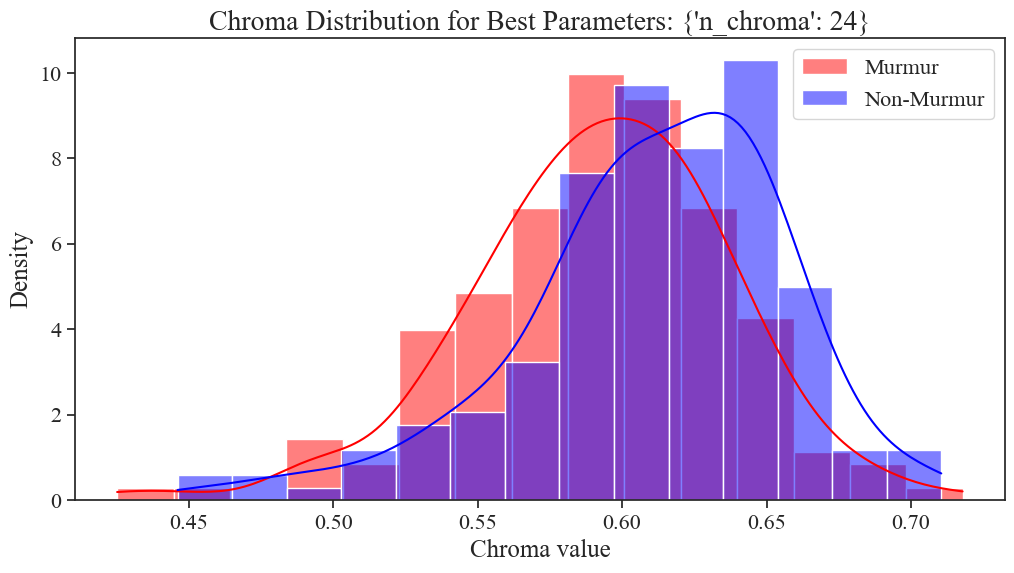

In [24]:
from itertools import product

def calculate_feature_distribution(audio_signals, labels, feature_name, config):
    feature_values_murmur = []
    feature_values_non_murmur = []

    # calculate features and create list of values per class usign above functions
    for (signal, sr), label in zip(audio_signals, labels):
        feature_config = {feature_name: config}
        feature_dict = extract_librosa_features_config(signal, sr, feature_config)
        
        feature_values = [v for k, v in feature_dict.items() if k.lower().startswith(feature_name.lower())]
        mean_feature_value = np.mean(feature_values)
        
        if label == 1: 
            feature_values_murmur.append(mean_feature_value)
        else:
            feature_values_non_murmur.append(mean_feature_value)
    
    return feature_values_murmur, feature_values_non_murmur

def find_best_parameters(audio_signals, labels, feature_name, param_dict):
    best_params = None
    max_difference = 0

    # create all combinations of parameters to test based on defined params
    param_names = sorted(param_dict)
    param_combinations = product(*(param_dict[name] for name in param_names))
    
    # test all combinations, using tqdm to track progress
    for param_values in tqdm(param_combinations):
        config = dict(zip(param_names, param_values))
        feature_values_murmur, feature_values_non_murmur = calculate_feature_distribution(audio_signals, labels, feature_name, config)
        
        # get difference between distribuzions (mean difference here) --> could also explore other difference measures, but this is more intuitive
        mean_diff = np.abs(np.mean(feature_values_murmur) - np.mean(feature_values_non_murmur))
        
        if mean_diff > max_difference:
            max_difference = mean_diff
            best_params = config
    
    return best_params, max_difference

def plot_feature_distributions(feature_values_murmur, feature_values_non_murmur, feature_name, best_params):
    plt.figure(figsize=(12, 6))
    sns.histplot(feature_values_murmur, color='red', label='Murmur', kde=True, stat='density')
    sns.histplot(feature_values_non_murmur, color='blue', label='Non-Murmur', kde=True, stat='density')
    plt.legend()
    plt.title(f'{feature_name.title()} Distribution for Best Parameters: {best_params}')
    plt.xlabel(f'{feature_name.title()} value')
    plt.ylabel('Density')
    plt.show()


# define features and parameters
feature_name = 'chroma'
param_dict = {
    'n_chroma': [12, 16, 20, 24],
}


# find best parameters for given feature
best_parameters, _ = find_best_parameters(training_audio_signals, training_labels, feature_name, param_dict)
print(f"Best parameters for {feature_name}: {best_parameters}")

# calculate distributions for best parameter combination & plot
feature_values_murmur, feature_values_non_murmur = calculate_feature_distribution(training_audio_signals, training_labels, feature_name, best_parameters)
plot_feature_distributions(feature_values_murmur, feature_values_non_murmur, feature_name=feature_name, best_params=best_parameters)


#### Read different performance results CVSs to create overview plot of preprocessing conditions effects

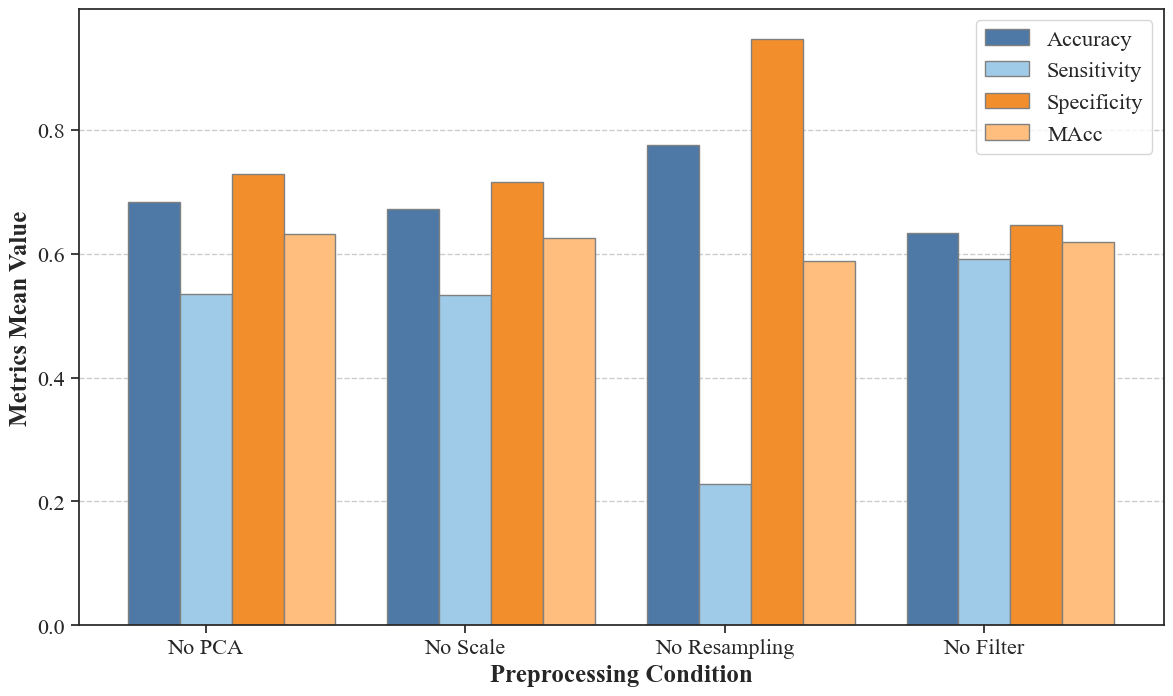

In [28]:
# read csvs (define path to files!)
no_resampling = pd.read_csv('data/model_performance_PCA_Macc_noresampling.csv')
no_filter = pd.read_csv('data/model_performance_nofilter_macc_downsampled.csv')
no_scale = pd.read_csv('data/model_performance_noScale_macc_downsampled.csv')
no_pca = pd.read_csv('data/model_performance_noPCA_macc_downsampled.csv')

# get mean values from files
means = {
    "Preprocessing": ["No PCA", "No Scale", "No Resampling", "No Filter"],
    "Accuracy": [no_pca['accuracy'].mean(), no_scale['accuracy'].mean(), no_resampling['accuracy'].mean(), no_filter['accuracy'].mean()],
    "Sensitivity": [no_pca['sensitivity'].mean(), no_scale['sensitivity'].mean(), no_resampling['sensitivity'].mean(), no_filter['sensitivity'].mean()],
    "Specificity": [no_pca['specificity'].mean(), no_scale['specificity'].mean(), no_resampling['specificity'].mean(), no_filter['specificity'].mean()],
    "MAcc": [no_pca['macc'].mean(), no_scale['macc'].mean(), no_resampling['macc'].mean(), no_filter['macc'].mean()]
}

means_df = pd.DataFrame(means)


fig, ax = plt.subplots(figsize=(14, 8))
barWidth = 0.2
r1 = np.arange(len(means_df['Preprocessing']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# colours that are better matching to other plots created as part of this project
colors = ['#4E79A7', '#A0CBE8', '#F28E2B', '#FFBE7D', '#59A14F', '#8CD17D', '#B6992D', '#F1CE63', '#499894', '#86BCB6']

# plot every bar with colours defined above
ax.bar(r1, means_df['Accuracy'], color=colors[0], width=barWidth, edgecolor='grey', label='Accuracy')
ax.bar(r2, means_df['Sensitivity'], color=colors[1], width=barWidth, edgecolor='grey', label='Sensitivity')
ax.bar(r3, means_df['Specificity'], color=colors[2], width=barWidth, edgecolor='grey', label='Specificity')
ax.bar(r4, means_df['MAcc'], color=colors[3], width=barWidth, edgecolor='grey', label='MAcc')

# set labels and ticks
ax.set_xlabel('Preprocessing Condition', fontweight='bold')
ax.set_ylabel('Metrics Mean Value', fontweight='bold')
ax.set_xticks([r + barWidth for r in range(len(means_df['Preprocessing']))])
ax.set_xticklabels(means_df['Preprocessing'])
ax.legend()

plt.grid(axis='y', linestyle='--')

plt.show()


## Part 4: Your Own Data [10 marks]

In this part, you'll have the opportunity to record your own heart sounds data and analyse it. You'll need a smartphone and a voice recorder app, or a pair of headphones and a voice recorder app. We recommend Voice Record Pro.

Place the microphone on your smartphone on the left hand side of your chest (where your heart is), facing your chest. Sit still in a quiet environment and record 2 minutes of your own heart sounds data.

If you are unable to record your own data, please contact Kayla (kjb85) or Jake (js2372).

Your data must be uploaded to moodle with your colab and answer sheet.

**Task 4.1**: Read in the data and visualise it appropriately.


---

❓ What differences are there between the frequency spectrums of your recording and the files we provided? Discuss why there might be differences.

In [29]:
# Two Recordings: first one most likely with more background noise than second one
# tlh1_signal, tlh1_sr = librosa.load('/content/drive/MyDrive/Cambridge/Studies/Lent/MobileHealth/Assessment1/tlh45_heartbeat_recording_1.wav", sr=None)
# tlh2_signal, tlh2_sr = librosa.load("/content/drive/MyDrive/Cambridge/Studies/Lent/MobileHealth/Assessment1/tlh45_heartbeat_recording_2.wav", sr=None)

tlh1_signal, tlh1_sr = librosa.load("data/tlh45_heartbeat_recording_1.wav", sr=None)
tlh2_signal, tlh2_sr = librosa.load("data/tlh45_heartbeat_recording_2.wav", sr=None)

print(f"Data loaded successfully. First Recording SR: {tlh1_sr}, Second Recording SR: {tlh2_sr}")

Data loaded successfully. First Recording SR: 48000, Second Recording SR: 48000


In [30]:
# calculate time
tlh1_time = np.linspace(0, len(tlh1_signal) / tlh1_sr, num=len(tlh1_signal))
tlh2_time = np.linspace(0, len(tlh2_signal) / tlh2_sr, num=len(tlh2_signal))

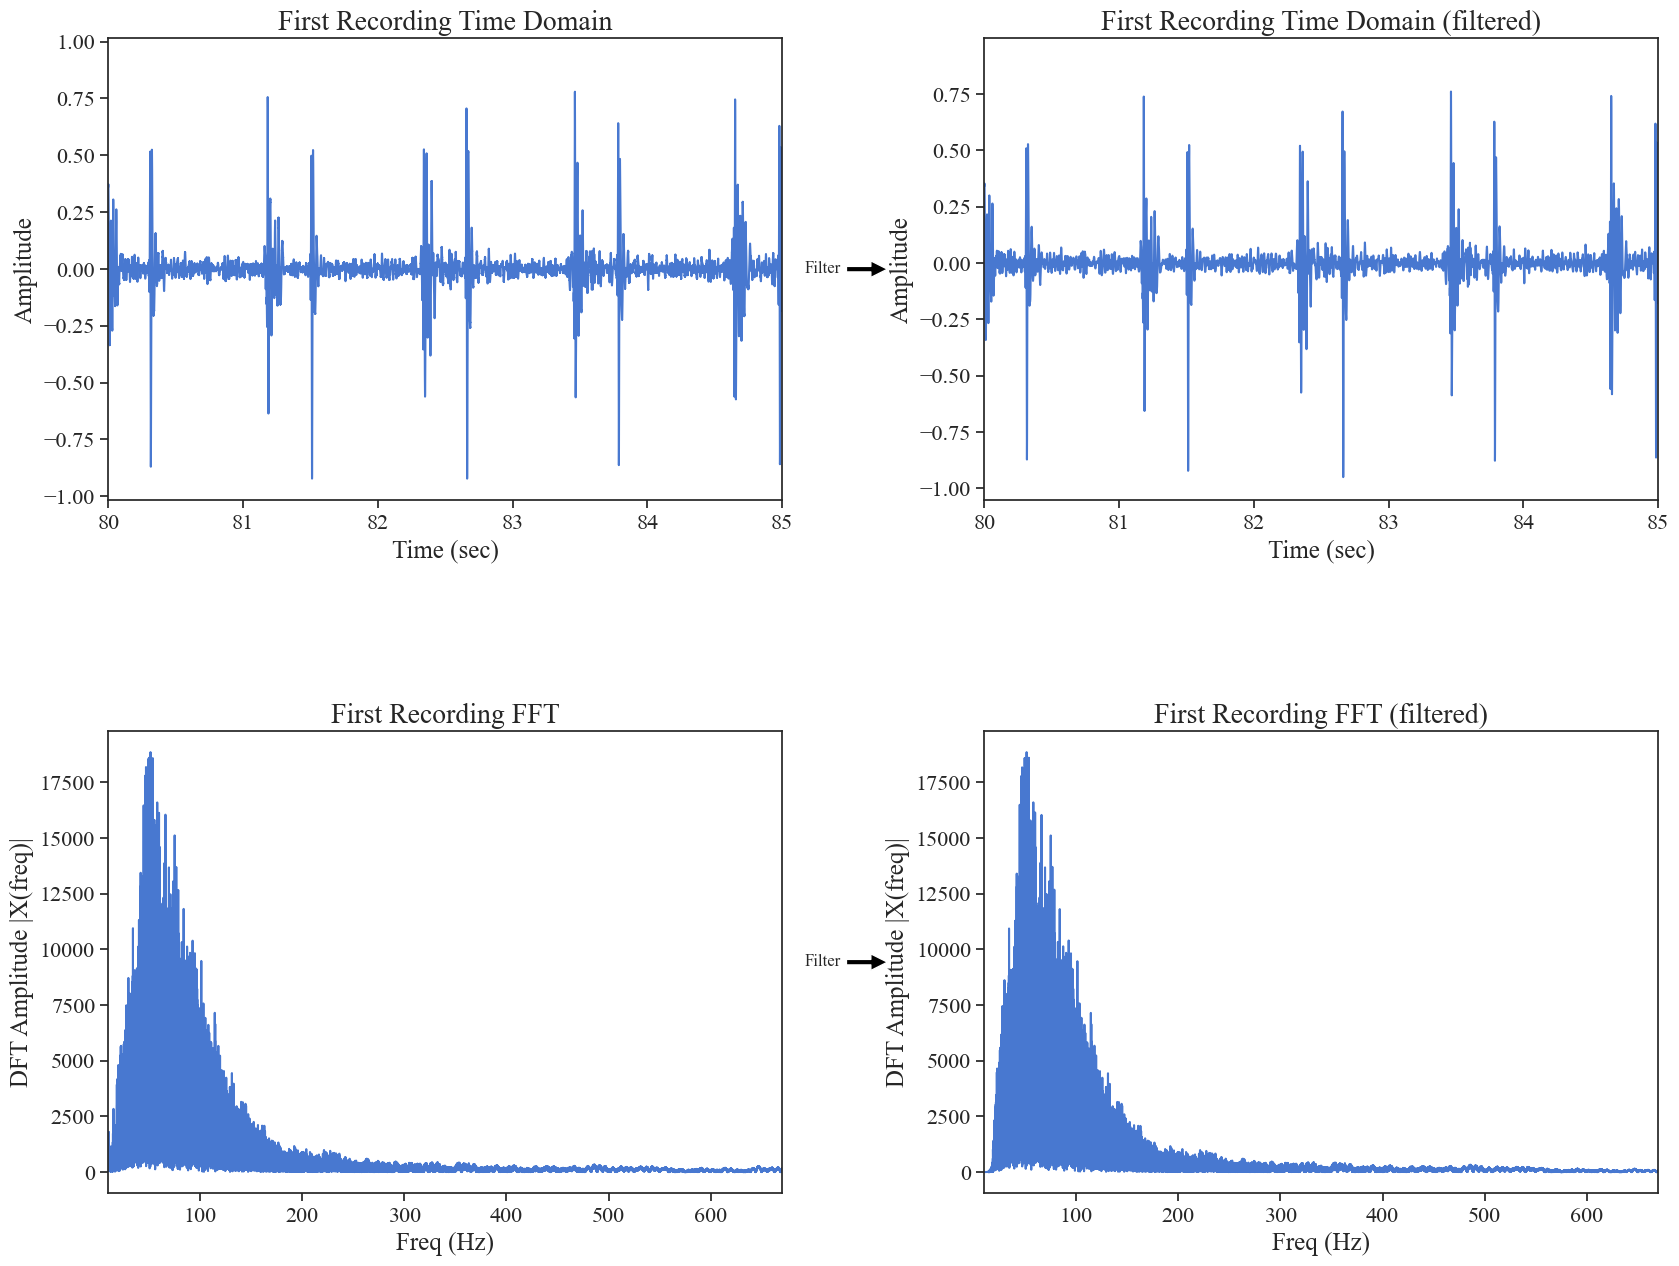

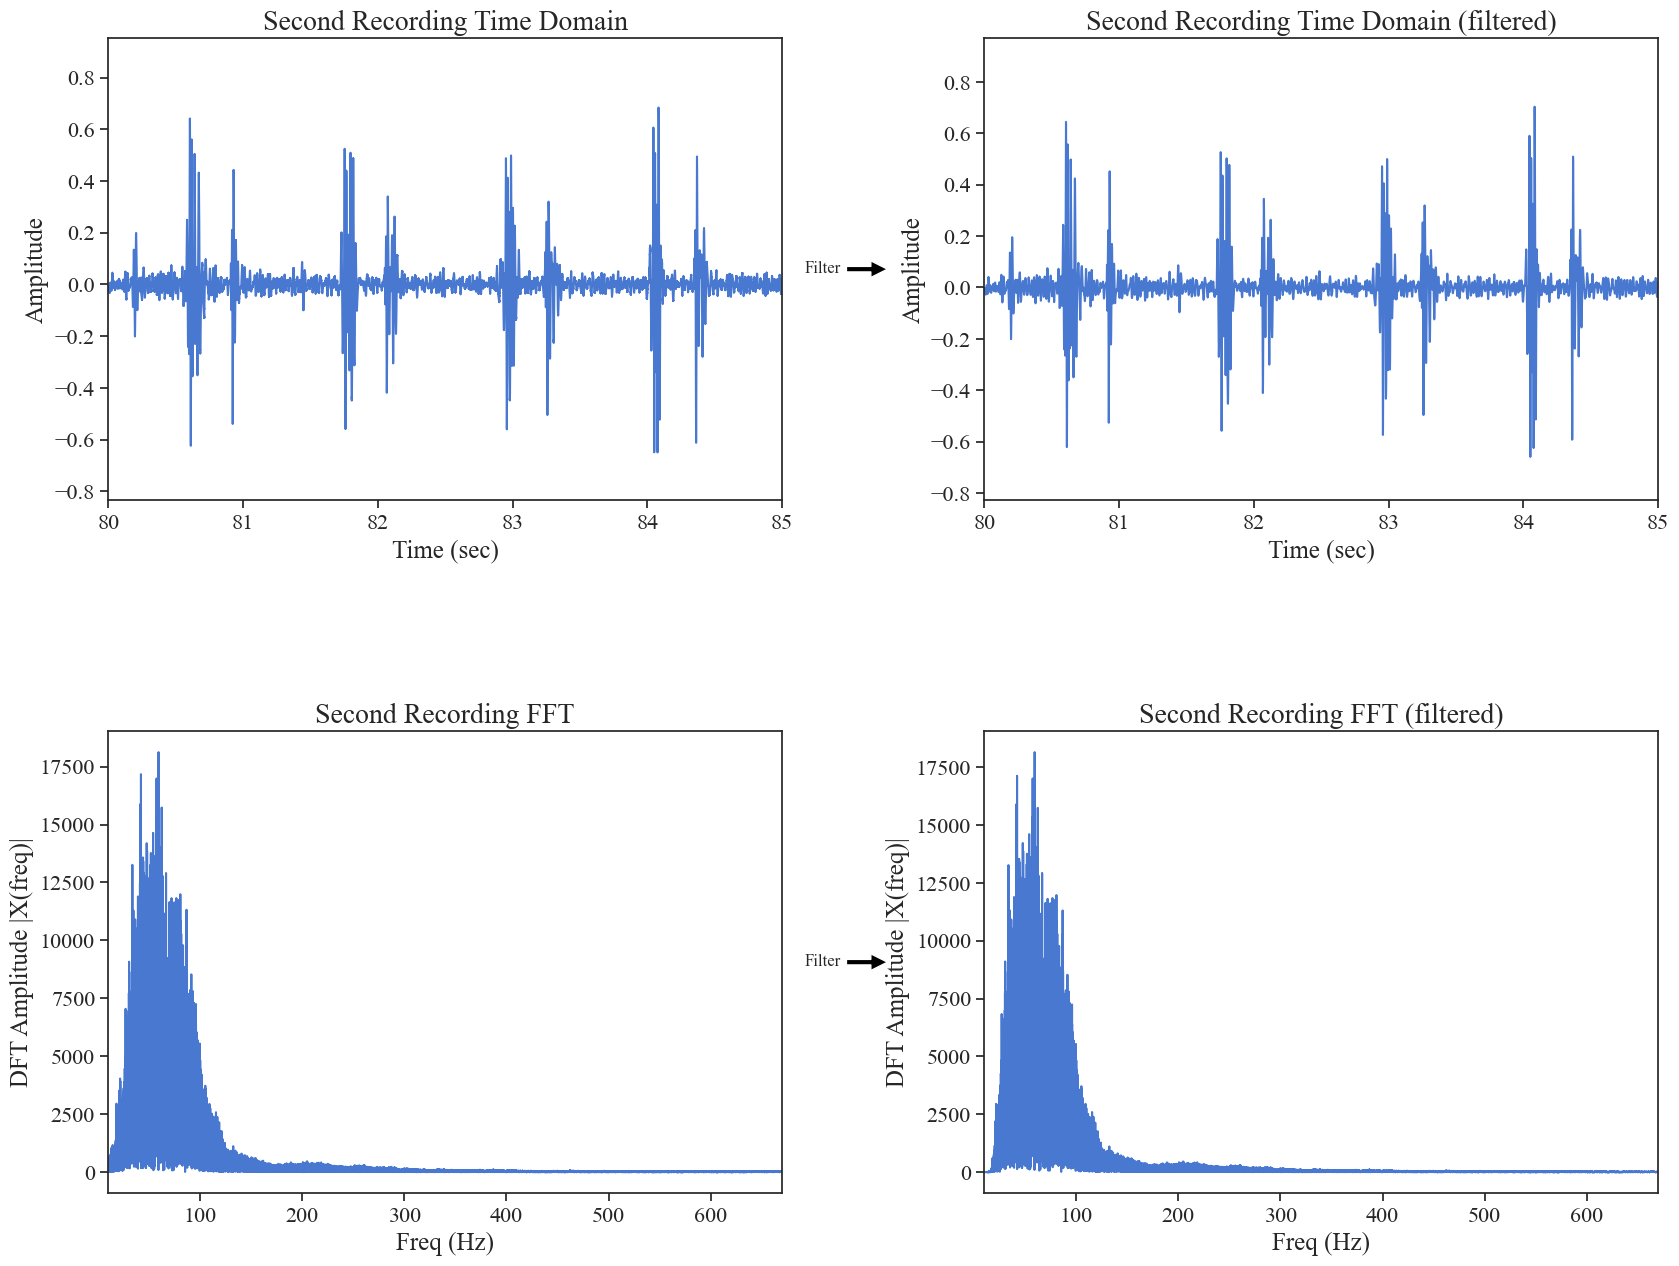

In [31]:
# filter signal (i.e. remove noise)
low_cutoff = 20 # 200 for cutting off main parts of hb
high_cutoff = 660
tlh1_signal_filtered = butter_bandpass_filter(tlh1_signal, low_cutoff, high_cutoff, tlh1_sr, 6)
tlh2_signal_filtered = butter_bandpass_filter(tlh2_signal, low_cutoff, high_cutoff, tlh2_sr, 6)


# Show First Recording Plots (unfiltered & filtered)
xlim_time = (80, 85)
ylim_time = None # (-0.3, 0.3)

xlim_fft = (max(0, low_cutoff-10), high_cutoff+10) # show a bit more than cutoff frequencies

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

plot_time_domain(tlh1_signal, tlh1_time, 'First Recording Time Domain', row=2, col=2, index=1, xlim=xlim_time, ylim=None) # unfiltered
plot_time_domain(tlh1_signal_filtered, tlh1_time, 'First Recording Time Domain (filtered)', row=2, col=2, index=2, xlim=xlim_time, ylim=None) # filtered
plt.annotate('Filter', **annotation_props)


plot_frequency_domain(tlh1_signal, tlh1_sr, 'First Recording FFT', row=2, col=2, index=3, xlim=xlim_fft, ylim=None) # unfiltered
plot_frequency_domain(tlh1_signal_filtered, tlh1_sr, 'First Recording FFT (filtered)', row=2, col=2, index=4, xlim=xlim_fft, ylim=None) # filtered
plt.annotate('Filter', **annotation_props)

plt.show()


# Show plots (unfiltered & filtered)
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

plot_time_domain(tlh2_signal, tlh2_time, 'Second Recording Time Domain', row=2, col=2, index=1, xlim=xlim_time, ylim=None) # unfiltered
plot_time_domain(tlh2_signal_filtered, tlh2_time, 'Second Recording Time Domain (filtered)', row=2, col=2, index=2, xlim=xlim_time, ylim=None) # filtered
plt.annotate('Filter', **annotation_props)


plot_frequency_domain(tlh2_signal, tlh2_sr, 'Second Recording FFT', row=2, col=2, index=3, xlim=xlim_fft, ylim=None) # unfiltered
plot_frequency_domain(tlh2_signal_filtered, tlh2_sr, 'Second Recording FFT (filtered)', row=2, col=2, index=4, xlim=xlim_fft, ylim=None) # filtered
plt.annotate('Filter', **annotation_props)

plt.show()

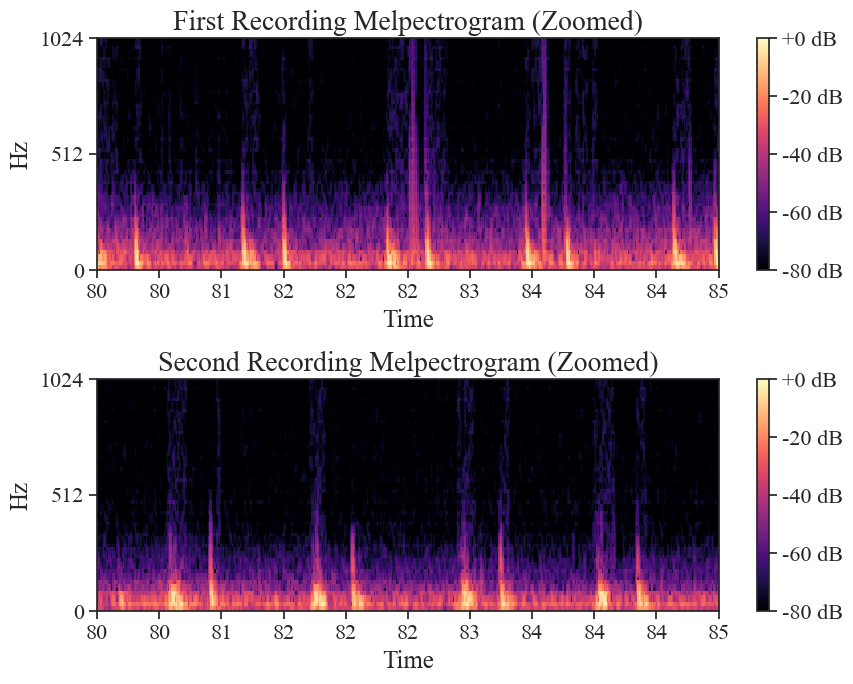

In [32]:
# Plot melspectograms:
plt.figure(figsize=(9, 7))

plt.subplots_adjust(hspace=0.5, wspace=0.3)

xlim_mel = (80, 85)
ylim_mel = (0, 1024)# None # (-0.3, 0.3)

plot_melspectrogram(tlh1_signal, tlh1_sr, 'First Recording Melpectrogram (Zoomed)', row=2, col=1, index=1, xlim=xlim_mel, ylim=ylim_mel, n_fft=2048, hop_length=512, n_mels=256)
plot_melspectrogram(tlh2_signal, tlh2_sr, 'Second Recording Melpectrogram (Zoomed)', row=2, col=1, index=2, xlim=xlim_mel,ylim=ylim_mel,  n_fft=2048, hop_length=512, n_mels=256)

plt.show()